# 1. Introduction
The purpose of this notebook is to assess the profit opportunity of quantile trading strategy based on factors prediction.

**Underlying Rationale**
Though traditional financial ratios offer valuable insights into a company's financial health, they may not always provide the most timely or comprehensive perspective for quantile trading. A factor-based approach, with its focus on predictive analytics and a broader set of variables, can offer a more dynamic and potentially more profitable strategy for navigating the complexities of the US equity market. Therefore, in this notebook, we will try to construct a dynamic quantile trading strategy based on factor and equity return prediction.

**Main Structure**
Compared with traditional quantile trading strategy based on single well-known factor, e.g. P/E, our approach has the following 4 updates:
1. Construct more factors from academic research 
2. Try different methods to select best factors for each period
3. Try different linear models to prediction single stock return 
4. Try different portfolio allocation method

Through above 4 steps, we intend to find a refined quantile trading strategy which can generate better performance and obtain a understanding the mechanism behind this type of portfolio.

In [121]:
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import seaborn as sns
from sklearn.metrics import r2_score
from seaborn import heatmap
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import VAR

import warnings
warnings.filterwarnings('ignore')

from src import *

from typing import Callable
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [122]:
INIT_CAPITAL = 1e6
TEST_START_DATE = datetime(2007, 5, 31)

# 2. Data

We mainly obtain price and financial data from Quandl database (EOD and Zacks). The preprocess of data contains 3 major parts:
1. Universe selection
2. Ratio calculation
3. Return calculation

We then perform exploratory data analysis (EDA) on ratios and factor returns to guide our prediction model construction.

## 2.1. Universe

We select our universe by filtering available tickers in ZACKS which fits following conditions:
1. Listed on NASDAQ / NYSE
2. active as of now
3. belonging to S&P500 as of now
4. not belonging to Finance / Automobile sector
<br>

##### Why S&P500?
We understand using current S&P500 member introduces look ahead bias. There are a few reasons for this decision:
- constructing a portfolio from a subset of stocks in S&P guaranteed relatively high liquidity and low short interest;
- universe selection is not the focus of this project;
- we would later compare our performance with market return, i.e. S&P500 returns (for true apple-to-apple comparison, we should form our own S&P index with all tickers in our universe with value-weighted return series. But using custom index would prevent us from make direct comparison with others' strategy.)

Our trading strategy forms a long-short portfolio with relatively low trading cost level and short interest rate (1-month bill rate + 100bp). Using highly liquid large cap stocks allows our assumption to be more realistic in a sense.
<br>

##### Why remove Finance/Auto?
We remove finance / automotive sector since their financial reports follows different format (i.e. loan = receivable = assets). And this may lead to misinterpretation on certain financial ratios. 

In [2]:
tickers = find_valid_universe()
print(f"Our universe contains {len(tickers)} tickers in total.")

URLError: <urlopen error [Errno 8] nodename nor servname provided, or not known>

In [21]:
latest_zacks = get_zacks(
    use_cache=True, 
    tickers=tickers, 
    start_date="2023-09-30"
)
latest_zacks = latest_zacks.sort_values("per_end_date").groupby("ticker").last()

#### Universe Composition

We show composition of our universe by the following 2 graphs:
1. pie chart: number of ticker in each sector 
2. box plot: market value distribution of stocks in each sector (we also highlight the name of top 10 stock with the highest market value on more recent reporting date).

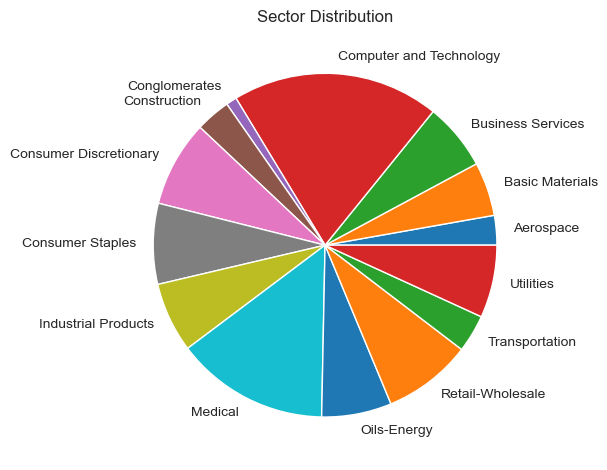

In [22]:
sector_map = {
    1: "Consumer Staples",
    2: "Consumer Discretionary",
    3: "Retail-Wholesale",
    4: "Medical",
    5: "Auto-Tires-Trucks",
    6: "Basic Materials",
    7: "Industrial Products",
    8: "Construction",
    9: "Conglomerates",
    10: "Computer and Technology",
    11: "Aerospace",
    12: "Oils-Energy",
    13: "Finance",
    14: "Utilities",
    15: "Transportation",
    16: "Business Services",
}
latest_zacks.loc[:, "sector_name"] = latest_zacks["zacks_sector_code"].map(sector_map)
def plot_pie_sector():
    sec_count = latest_zacks.groupby("sector_name")["per_end_date"].count()
    sec_count.name = None
    sec_count.plot.pie(y="count", title="Sector Distribution")
    plt.tight_layout()

plot_pie_sector()

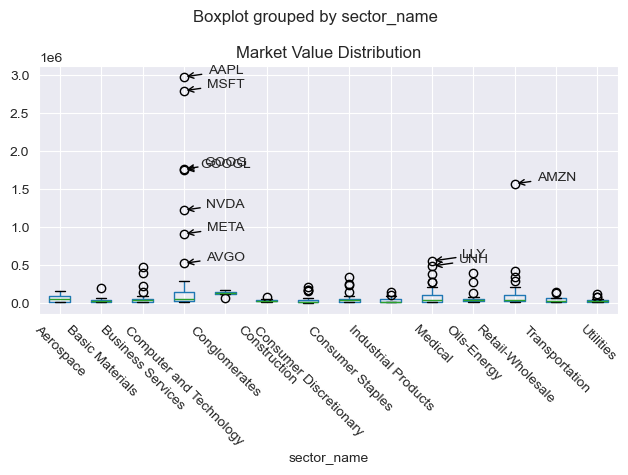

In [23]:
def plot_hist_mkt_val():
    ax = latest_zacks.boxplot(by="sector_name", column="mkt_val", rot=-45)
    ax.set_title("Market Value Distribution")
    tick_map = {t._text: t._x for t in ax.get_xticklabels(minor=False)}
        
    for ticker, row in latest_zacks.nlargest(10, "mkt_val").iterrows():
        x_position = tick_map[row["sector_name"]]
        y_position = row['mkt_val']
        
        # Annotate with ticker names
        ax.annotate(ticker, xy=(x_position, y_position), xytext=(30, 0),
                    textcoords='offset points', ha='center', va='bottom',
                    arrowprops=dict(arrowstyle='->', color='black'))    
    plt.tight_layout()

plot_hist_mkt_val()

# 2.2. Ratios

We select ratios from different aspects in attempt to capture different risks and profit opportunity in equity market. We construct 27 basic financial and techinal indicators, and also calculate 40 new factors from various source. 


**1. Basic Financial & Technical Indicators**

We make use of zacks' financial ratios database (n = 23). Zacks contains 26 ratios in total, which includes 3 insurance company specific ratios). We also adjust all equity / asset based ratios to reflect market value at each timestamp.

In addition, we add P/E ratio as value factor to capture the classic HML (high-minus-low) factor return as mentioned in Fama-French 3 factor model.

We calculate following technical indicator to capture momentum effect on return:
1. ret_0_1: past 1 month return;
2. ret_1_6: 1 month ago - 6 month ago return;
3. ret_6_12: 6 month ago - 12 month ago return. We separate past return in above 3 factors because is a usual practice to separate short-term reversal and long-term trend on returns. 
4. skew: past 1 year daily return skewness.
5. volume_shock: recent 1 week mean volume / recent 3 month mean volume to evaluate whether there exists abnormally high volume recently.
6. rs_volatility: Rogers-Satchell volatility to measure the volatility for securities with non-zero mean. It tends to under-estimates the volatility since it ignore overnight price jump.

To be specific, we use **exponential weighted average (EMW)** instead of boxcar average for mean price / volume calculation to make sure recent data is more relevant and there will be no abrupt parameter change due to remove of an outlier sample after certain time. For example, we use half life = 3 days EMW for 1-week average mentioned above.

**2. New Factors**

The factors and the related calculation are shown below. Most of the factor are **momentum factors**, which we found positive impact on our strategy.


| Factor Name                                 | Shortname     | Equation                                                                                                                                                                                                                     | Category   |
|:--------------------------------------------|:--------------|:-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:-----------|
| Fluctuation                                 | fluc          | max(close)-min(close)/mean(close) (time window=20 days)                                                                                                                                                                      | Momentom   |
| MACD                                        | macd          | DIF=EMA(short)-EMA(long)                                                                                                                                                                                                     | Momentum   |
| Bias                                        | bias          | the difference percentage of today's close and N-day rolling average (time window=20 days)                                                                                                                                   | Momentum   |
| Winning Percentage                          | win_pct       | the percentage of return>0 in a certain period(time window=60 days)                                                                                                                                                          | Momentum   |
| Highest 95 Percent                          | quantile_95   | the 95% quantile of return in a certain period(time window=60 days)                                                                                                                                                          | Momentum   |
| Kurt Skew Combination                       | kurt_skew     | (kurt + skew)/2                                                                                                                                                                                                              | Momentum   |
| Ulcer Index                                 | ulcer         | nan                                                                                                                                                                                                                          | Momentum   |
| Price Position                              | price_pos     | (close-min(close))/(max(close)-min(close)) time window=20 days                                                                                                                                                               | Momentum   |
| Chande Momentum Oscillator                  | cmo           | nan                                                                                                                                                                                                                          | Momentum   |
| Z-Score                                     | z_score       | (ret - mean(ret))/std(ret) time window=60 days                                                                                                                                                                               | Momentum   |
| Cash-based operating profitability          | cash_profit   | Operating profitability net of non-cash component                                                                                                                                                                            | Accounting |
| revenue growth                              | rev_growth    | nan                                                                                                                                                                                                                          | Accounting |
| Illiquidity                                 | illiquidity   | Liquidity proxied by the turnover rate: number of shares traded as a fraction of the number of shares outstanding                                                                                                            | Momentum   |
| Excluded expenses                           | excl_exp      | Excluded expenses in firm's earnings reports                                                                                                                                                                                 | Accounting |
| R&D reporting biases                        | rd_bias       | R&D reporting biases proxied by the difference between R&D growth and earnings growth                                                                                                                                        | Accounting |
| Return predictability                       | ret_autocorr  | Short-term (one month) and long-term (twelve months) serial correlations in returns                                                                                                                                          | Momentum   |
| Return consistency                          | ret_consist   | Consecutive returns with the same sign                                                                                                                                                                                       | Momentum   |
| Asset growth                                | asset_growth  | Year-on-year percentage change in total assets                                                                                                                                                                               | Accounting |
| Parkinson volatility                        | p_volatility  | nan                                                                                                                                                                                                                          | Momentum   |
| Yang-Zhang volatility                       | yz_volatility | nan                                                                                                                                                                                                                          | Momentum   |
| 20 day annualized return variance           | V20           | Variance of annualized returns of individual stocks in the last 20 days                                                                                                                                                      | Technical  |
| 20 day return kurtosis                      | K20           | 20 day kurtosis of individual stock returns                                                                                                                                                                                  | Technical  |
| 10 day average turnover rate                | TURN10        | Average turnover rate of individual stocks in the last 10 days                                                                                                                                                               | Technical  |
| Moving average of 12 day trading volume     | VEMA12        | Moving average of 12 day trading volume of individual stocks                                                                                                                                                                 | Technical  |
| Standard deviation of 20 day trading volume | VSTD20        | Standard deviation of trading volume of individual stocks in the last 20 days                                                                                                                                                | Technical  |
| Buying and selling momentum rate            | AR            | (sum of 26 days (highest price of the day – opening price of the day) / sum of 26 days (opening price of the day – lowest price of the day) * 100%                                                                           | Technical  |
| Willingness to buy rate                     | BR            | (sum of 26 days (the highest price of the day - yesterday’s closing price) / sum of 26 days (yesterday’s closing price – the lowest price of the day) * 100%                                                                 | Technical  |
| Arron up                                    | AU            | ((calculation period days – days after the highest price) / calculation period days) * 100%                                                                                                                                  | Technical  |
| Arron down                                  | AD            | ((calculation period days – days after the lowest price) / calculation period days) * 100%                                                                                                                                   | Technical  |
| Net profit margin on sales                  | NPR           | net profit / operating income                                                                                                                                                                                                | Financial  |
| Retained earnings per share                 | RPPS          | retained profit / closing share capital                                                                                                                                                                                      | Financial  |
| Altman’s Z-score                            | nan           | nan                                                                                                                                                                                                                          | Financial  |
| BIAS Volume                                 | biasvol       | BIASVOL(N)=(VOLUME-MA(VOLUME,N))/MA(VOLUME,N)                                                                                                                                                                                | Momentum   |
| Bull Power                                  | ERBU          | BullPower=HIGH-EMA(CLOSE,N)                                                                                                                                                                                                  | Momentum   |
| Bear Power                                  | ERBE          | BearPower=LOW-EMA(CLOSE,N)                                                                                                                                                                                                   | Momentum   |
| FI                                          | FI            | Use the change of price to measure the trend of price, and use the volume to measure the strength of the trend.                                                                                                              | Momentum   |
| HMA                                         | HMA           | HMA=MA(HIGH,N)                                                                                                                                                                                                               | Momentum   |
| PVO                                         | PVO           | The exponential moving average of trading volume is used to reflect the change of trading volume                                                                                                                             | Momentum   |
| DPO                                         | DPO           | DPO is the difference between the current price and the delayed moving average, which reduces the influence of long-term trends on short-term price movements by removing the moving average of the previous period of time. | Momentum   |
| DC                                          | DC            | The DC index uses the n-day high and n-day low to construct the upper and lower tracks of price change.                                                                                                                      | Momentum   |
| alpha101 #6                                 | alpha6        | (-1 * correlation(open, volume, 10))                                                                                                                                                                                         | Momentum   |
| alpha101 #12                                | alpha12       | (sign(delta(volume, 1)) * (-1 * delta(close, 1)))                                                                                                                                                                            | Momentum   |

In [3]:
ratio = calc_ratio(use_cache=True, use_data_cache=True, tickers=tickers
                   ).dropna(how="all", axis=1)
ratio_col = list(set(ratio_col).intersection(ratio.columns))
ratio.shape

(98574, 69)

In [25]:
print(f"Ratio list (n={len(ratio_col)}): {ratio_col}")

Ratio list (n=68): ['profit_margin', 'ret_6_12', 'PVO', 'book_val_per_share', 'Altman_Z_Score', 'BIASVOL', 'fluc', 'excl_exp', 'BR', 'rd_bias', 'DC', 'asset_growth', 'tot_debt_tot_equity', 'p_volatility', 'pretax_profit_margin', 'z_score', 'VEMA12', 'AU', 'ret_asset', 'oper_profit_margin', 'TURN10', 'ret_invst', 'ERBE', 'cash_profit', 'price_pos', 'free_cash_flow_per_share', 'cmo', 'RPPS', 'HMA', 'ulcer', 'K20', 'gross_margin', 'bias', 'alpha6', 'free_cash_flow', 'NPR', 'DPO', 'curr_ratio', 'day_sale_rcv', 'rev_growth', 'illiquidity', 'ERBU', 'invty_turn', 'FI', 'ebit_margin', 'AD', 'ret_autocorr', 'AR', 'ret_tang_equity', 'rcv_turn', 'kurt_skew', 'win_pct', 'volume_shock', 'macd', 'lterm_debt_cap', 'pe', 'VSTD20', 'oper_cash_flow_per_share', 'yz_volatility', 'skew', 'ret_1_6', 'V20', 'ret_equity', 'alpha12', 'ret_0_1', 'asset_turn', 'rs_volatility', 'quantile_95']


#### Correlation

We examine the correlation between next 1 month returns and ratios or change of ratios.

From heatmap (1) - Ratios vs Returns, we find:
- No ratio has high correlation with next 1-month return (i.e. forward return). Since quantile trading has been well-known to practitioners, any obvious relationship would be quickly hedge away. Therefore, this result is not out of expectation.
- Some ratios show significant positive / negative correlation due to similar formula used in their calculation, e.g. oper_profit_margin (operating profit margin) and ebit_margin (EBIT margin). This also reminds our of potential multicollinearity problem for any linear model in prediction.

From heatmap (2) - Change of Ratios vs Change of Returns, we find:
- Change of some ratio has decent correlation with change of next month returns, e.g. asset_turn (asset turnover - efficiency improvement?) and ret_0_1 (past 1 month return - momentum effects?).


Text(0.5, 1.0, 'Correlation - Ratios vs Returns')

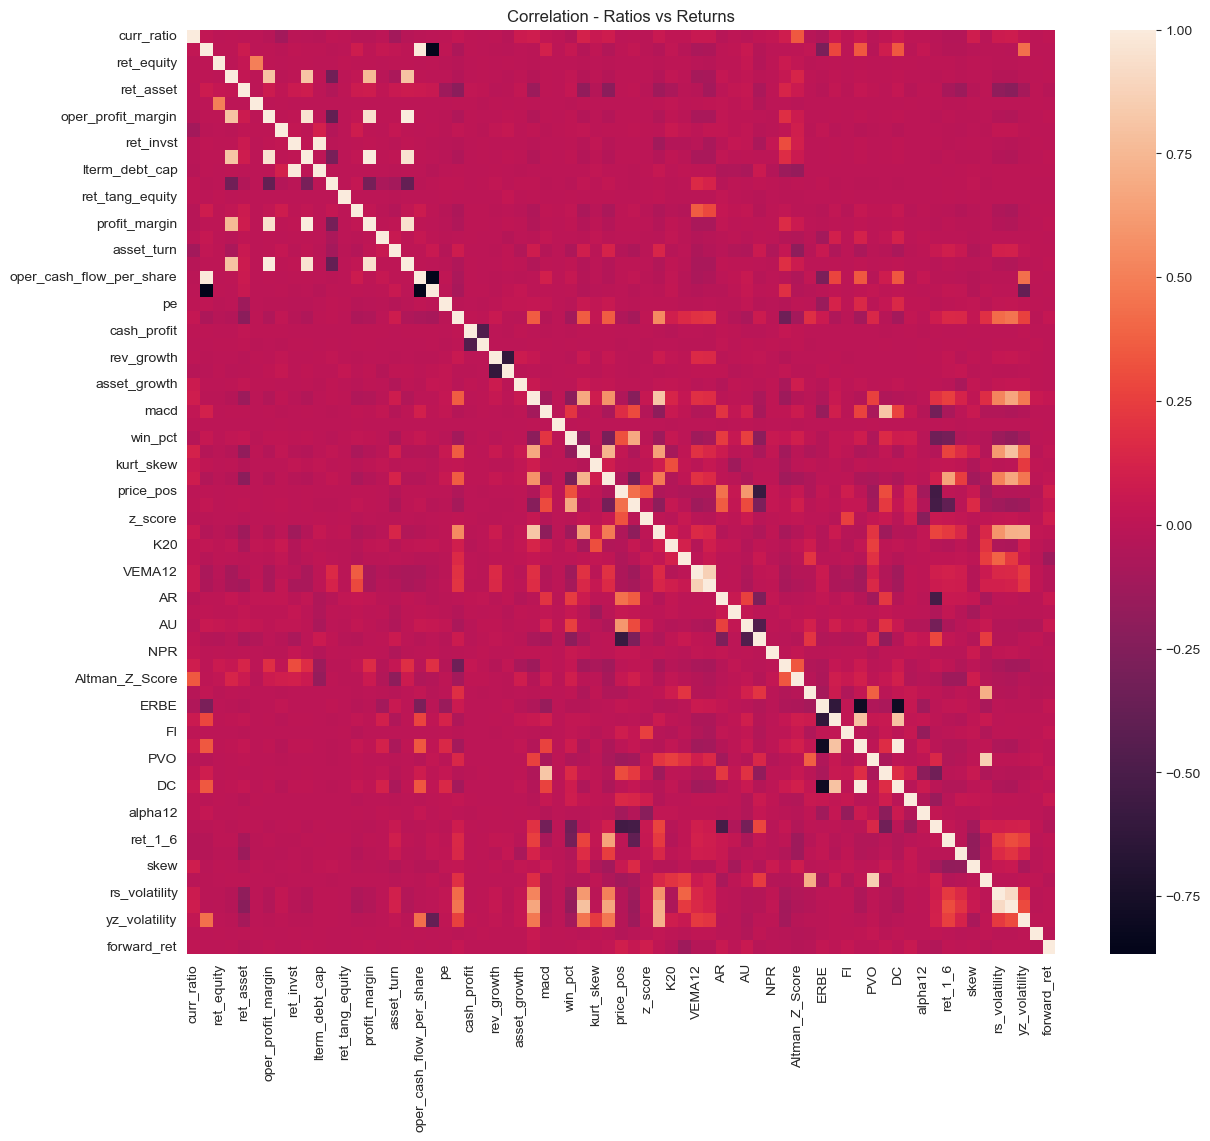

In [26]:
plt.figure(figsize=(14, 12))
ax = heatmap(ratio.corr())
ax.set_title("Correlation - Ratios vs Returns")

Text(0.5, 1.0, 'Correlation - Change of Ratios vs Change of Returns')

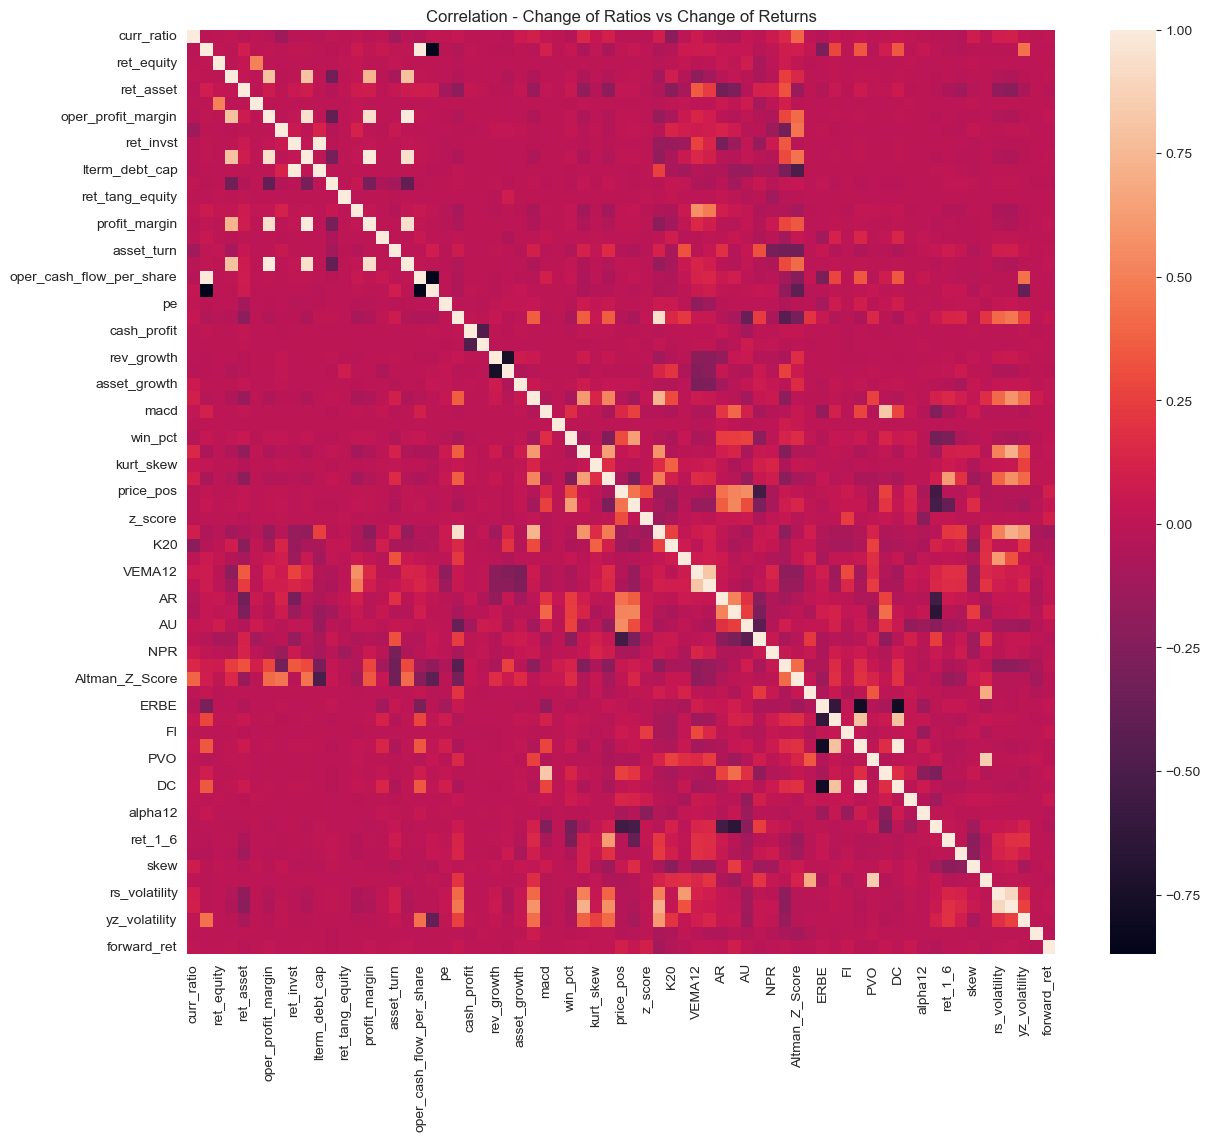

In [27]:
plt.figure(figsize=(14, 12))
ax = heatmap(ratio.diff().corr())
ax.set_title("Correlation - Change of Ratios vs Change of Returns")

##### Granger Causality
In the partial results shown from the Granger causality tests, various factors' abilities to predict the next period's return series are assessed. The p-values indicate the likelihood that the results could be due to chance: a lower p-value suggests a stronger relationship between the lagged values of the predictor series and the current value of the response series.

Most factors show p-values greater than the common significance level of 0.05, indicating that, individually, they do not have a statistically significant predictive power over the next period's returns. 

However, two factors stand out with p-values substantially below 0.05, suggesting that these factors may have predictive power. Particularly, the factor with the p-value of 0.0000 demonstrates a very strong evidence against the null hypothesis, suggesting a very strong predictive relationship with the next period's returns.

It's important to note that while Granger causality can indicate predictive relationships, it does not imply causation in the strictest sense. Moreover, economic and financial time series can be influenced by many interrelated factors, and overfitting is a potential risk in complex models.

For a thorough analysis, it would be essential to consider the economic significance of these results in addition to their statistical significance, assess the stability of the causality over time, and evaluate the performance of these factors within the context of a larger predictive model.

In [28]:
def granger_test(df):
    granger_p_val = {}
    for r in ratio_col:
        granger_p_val[r] = {
            "level": ts.grangercausalitytests(
                df[["forward_ret", r]].dropna(), maxlag=1
            )[1][0]["ssr_chi2test"][1],
            "difference": ts.grangercausalitytests(
                pd.concat([df["forward_ret"], df[r].diff()], axis=1).dropna(), maxlag=1
            )[1][0]["ssr_chi2test"][1],
        }
    return pd.DataFrame(granger_p_val).T.sort_values("level")

granger_test(ratio)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7460  , p=0.1864  , df_denom=74132, df_num=1
ssr based chi2 test:   chi2=1.7461  , p=0.1864  , df=1
likelihood ratio test: chi2=1.7461  , p=0.1864  , df=1
parameter F test:         F=1.7460  , p=0.1864  , df_denom=74132, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.3076  , p=0.0212  , df_denom=72138, df_num=1
ssr based chi2 test:   chi2=5.3079  , p=0.0212  , df=1
likelihood ratio test: chi2=5.3077  , p=0.0212  , df=1
parameter F test:         F=5.3076  , p=0.0212  , df_denom=72138, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0965  , p=0.2950  , df_denom=92579, df_num=1
ssr based chi2 test:   chi2=1.0965  , p=0.2950  , df=1
likelihood ratio test: chi2=1.0965  , p=0.2950  , df=1
parameter F test:         F=1.0965  , p=0.2950  , df_denom=92579, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.7902  

,level,difference
fluc,0.000024,0.802356
asset_growth,0.000056,0.290693
FI,0.000078,0.010324
ulcer,0.000083,0.362565
V20,0.000137,0.094800
...,...,...
rd_bias,0.966164,0.630746
Altman_Z_Score,0.968617,0.238510
rs_volatility,0.983524,0.623052
curr_ratio,0.992957,0.917133


## 2.3. Factors

Since BARRA factor model are not publicly-accessible. We estimate our own factor returns with ratio selected above and next 1-month forward return. 

We follow Fama and French's approach in estimating factors for their 3-factor model. For example, SMB (Small Minus Big) factor as the difference in returns between portfolios of small-cap and large-cap stocks:
$$\text{SMB} = \frac{1}{3} \times (\text{Small Value} + \text{Small Neutral} + \text{Small Growth}) - \frac{1}{3} \times (\text{Big Value} + \text{Big Neutral} + \text{Big Growth})$$

The SMB factor is constructed by first sorting stocks into two size groups (small and big) and then further into portfolios based on their book-to-market values. The returns of small-cap portfolios are then subtracted from the returns of large-cap portfolios to form the SMB factor. 

However, since we have 27 factors, the groups would become too small and trivial if divide each of them into 3 groups. Therefore, we adopt a simpler approach to use top 30% quantile average return minus bottom 30% quantile average return:
$$\text{Factor Return} = \text{Average Return}_{\text{Top 30\% by Ratio}} - \text{Average Return}_{\text{Bottom 30\% by Ratio}}
$$

In [4]:
factor = calc_factor(use_cache=False, ratio=ratio)
factor.shape

(290, 68)

#### Correlation

We also examine the correlation on factor returns and notice:
1. Some factors show significant positive / negative correlation like ratios. This is a definite proof of potential multicollinearity problem for any linear model in prediction.
2. Financial indicators in general tends to have smaller correlations with technical indicators. This could be due to their vastly different formula in calculation.

Text(0.5, 1.0, 'Correlation - Factors')

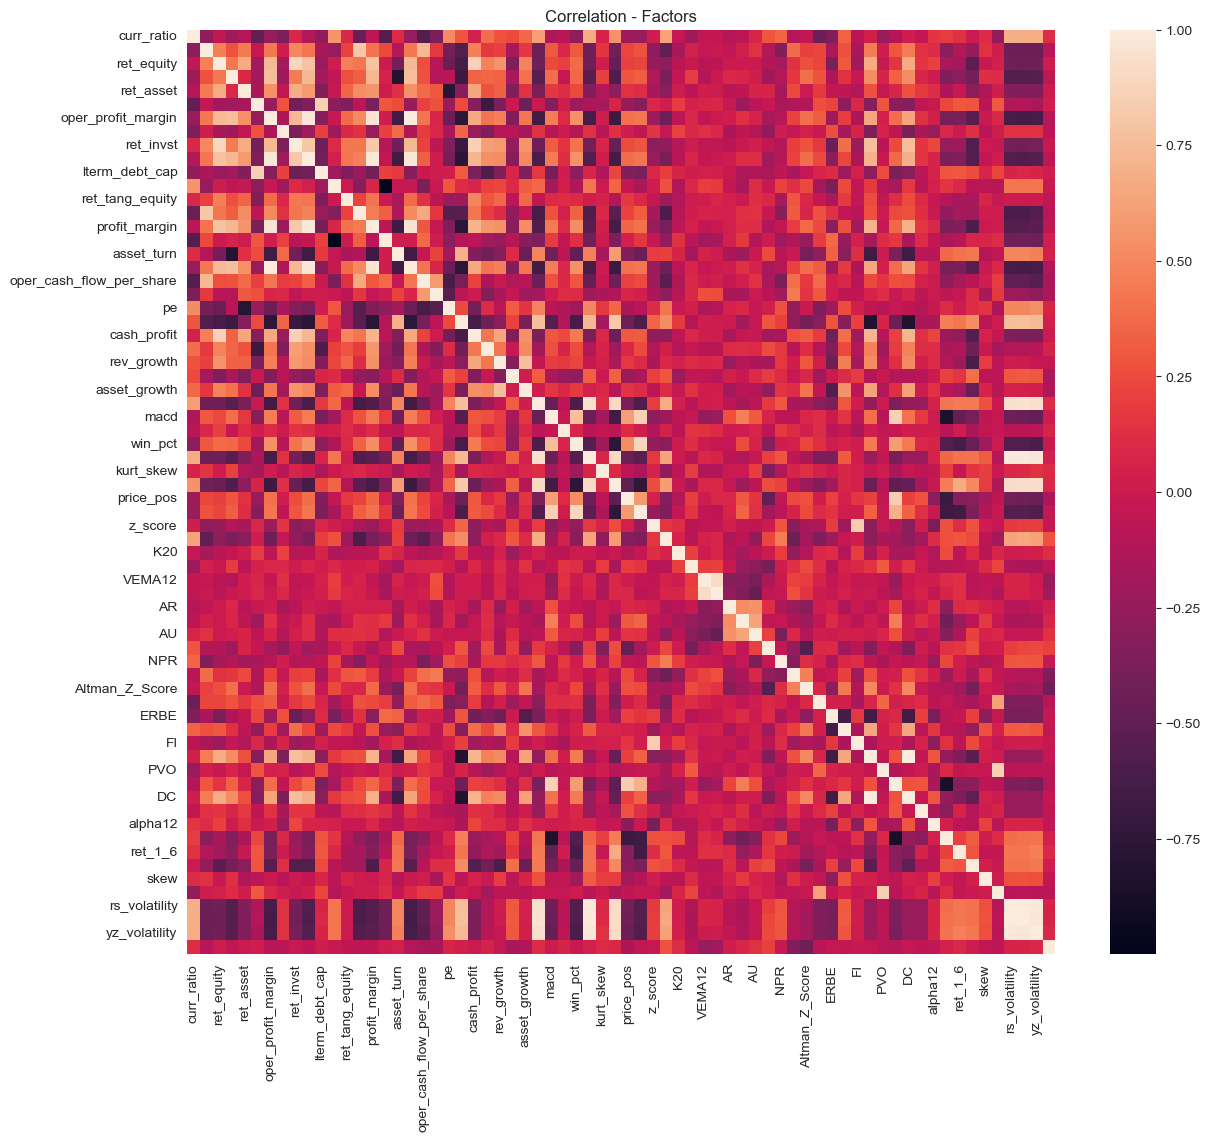

In [30]:
plt.figure(figsize=(14, 12))
ax = heatmap(factor.corr())
ax.set_title("Correlation - Factors")

##### AutoRegression
We also investigate the autocorrection of each factor return time-series.

Factors such as FI (Financial Indicators), BIASVOL, alpha12, VEMA12, and skew show extremely low p-values (close to zero) for their levels, indicating that these factors exhibit strong statistical significance in predicting returns over the selected time frame. The 'difference' column reinforces this significance, as the p-values are still considerably low, albeit higher than in the 'level' column. This suggests a robust differentiation in performance between stocks sorted by these factors.

On the other hand, factors such as free_cash_flow, ERBE, oper_cash_flow_per_share, and invty_turn have higher p-values in both columns, though still below the 0.05 threshold, indicating a less pronounced yet statistically significant effect.

The BR factor shows p-values bordering the conventional threshold for statistical significance, suggesting its predictive power may be weaker compared to the others mentioned.

Overall, the results imply that the factors with the lowest p-values could be more reliable for constructing a factor model to predict stock returns. However, it is crucial to consider the economic rationale behind each factor and not just their statistical significance. Additionally, the potential for overfitting and the stability of these relationships over time should be considered when incorporating these factors into a predictive model.

In [36]:
def adfuller_test(df):
    adfuller_p_val = {}
    n = len(ratio_col)
    # fig, axs = plt.subplots(n, 2, figsize=(6, n * 4))
    
    i = 0
    for r in ratio_col:
        adfuller_p_val[r] = {
            "level": adfuller(df[r].dropna())[1],
            "difference": adfuller(df[r].diff().dropna())[1],
        }
        # plot_acf(df[r].dropna(), ax=axs[i, 0])
        # plot_pacf(df[r].dropna(), ax=axs[i, 1])
        i += 1
    return pd.DataFrame(adfuller_p_val).T.sort_values("level")

adfuller_test(factor)

,level,difference
FI,0.000000e+00,5.525249e-16
BIASVOL,4.240763e-30,1.156459e-11
alpha12,2.530910e-29,2.346773e-14
skew,5.191933e-29,7.204643e-14
p_volatility,8.890744e-29,6.948067e-12
...,...,...
cash_profit,3.158632e-05,5.119349e-10
free_cash_flow,5.643146e-04,5.785290e-08
ERBE,8.745092e-04,1.435217e-18
invty_turn,1.706079e-02,9.134125e-11


# 2.4 Benchmark
Besides using market index, i.e. SPY, as benchmark, we also evaluate our results with other portfolio since our long-short portfolio is closer to market neutral portfolio, which is very different from the long-only setting in SPY.  

# 2.4.1. Factor
We first evaluate the performance of the single factor quantile trading strategy. We consider both using each factor as long indicator (i.e. buy high value) and short indicator (i.e. buy low value). 

As shown in the results table below, best few portfolios are:
1. **Buy High Rogers-Satchell Volatility**: The Rogers-Satchell volatility measure is a more sophisticated approach to estimating stock volatility, taking into account the intraday price range (high, low, opening, and closing prices). A strategy focusing on high Rogers-Satchell volatility targets stocks with significant intraday price movements, which could indicate a higher potential for profit-making through active trading. This measure can capture the unique characteristics of stocks that exhibit large intraday price swings without necessarily having high close-to-close volatility. Such stocks might provide opportunities for informed or skilled traders to exploit mispricings or to benefit from the greater range of trading opportunities presented by the stock's price movements within a day.

2. **Buy Low Past 6 Month Return**: This approach is based on the principle of mean reversion, which posits that asset prices and historical returns eventually move back towards the long-term mean or average level. By purchasing stocks that have underperformed in the recent past (e.g., over the last six months), investors might be positioning themselves to benefit from a potential correction or bounce-back as these stocks revert to their mean values. This strategy can be particularly effective in markets or sectors where short-term fluctuations are more noise than signal, allowing for the exploitation of temporary market irrationalities or overreactions.

3. **Buy Low B/M (Book-to-Market) Ratio**: A low B/M ratio can indicate that a company's stock is undervalued relative to its book value, a fundamental indicator of a company's intrinsic value. This value investing strategy assumes that the market will correct over time, recognizing the inherent value of these undervalued assets, leading to potential capital gains for early investors. Stocks with low B/M ratios are often considered to be "value stocks," and numerous studies, including the seminal Fama and French three-factor model, have found that value stocks tend to outperform growth stocks (those with high B/M ratios) over long periods, which is attributed to the risk-reward profile and market inefficiencies in pricing these assets.

However, none of the portfolio shows sharpe ratio higher than 0.3, which is equivalent to sharpe ratio of SPY over past years. Therefore, our methods attempt to improve quantile trading and obtain better results.

In [26]:
df_ff = get_ff_data(use_cache=True).resample("M").ffill()
df_ff.shape

(313, 4)

In [27]:
price = pd.read_pickle("data/price.pkl")["adj_close"].unstack("ticker")
price = fill_price_dates(price, droplevel=False).ffill()
price.shape

(8822, 392)

In [34]:
trade_cls = CalcTrade(
    df_price=price,
    init_cap=INIT_CAPITAL
)

@cache_df("single_ratio_backtest")
def all_single_ratio_backtest():
    def single_ratio_backtest(ratio_name: str):
        position_indicator = calc_position_by_rank(
            df_price=price.loc["2007-05-31":], 
            df_ratio=ratio.unstack(),
            rank_formula=ratio_name,
            lb=0,
            ub=0.1,
            interval=None,
            use_change=False,
        )
        position = portfolio_equal_weighted(
            position_indicator=position_indicator,
            df_price=price,
            position_size=INIT_CAPITAL,    # We assume long = short side = 1 Million
        )
        summary_df = trade_cls.iter_dates(position=position)
        return eval_return(summary_df["total_ret"], df_ff=df_ff, ann_factor=12)
    
    single_ratio_results = {}
    for r in ratio_col:
        print(r)
        single_ratio_results[r] = single_ratio_backtest(r)
        single_ratio_results["-" + r] = single_ratio_backtest("-" + r)
    return pd.DataFrame(single_ratio_results).T.sort_values("sharpe", ascending=False)

In [35]:
all_single_ratio_backtest(use_cache=False)

profit_margin
ret_6_12
PVO
book_val_per_share
Altman_Z_Score
BIASVOL
fluc
excl_exp
BR
rd_bias
DC
asset_growth
tot_debt_tot_equity
p_volatility
pretax_profit_margin
z_score
VEMA12
AU
ret_asset
oper_profit_margin
TURN10
ret_invst
ERBE
cash_profit
price_pos
free_cash_flow_per_share
cmo
RPPS
HMA
ulcer
K20
gross_margin
bias
alpha6
free_cash_flow
NPR
DPO
curr_ratio
day_sale_rcv
rev_growth
illiquidity
ERBU
invty_turn
FI
ebit_margin
AD
ret_autocorr
AR
ret_tang_equity
rcv_turn
kurt_skew
win_pct
volume_shock
macd
lterm_debt_cap
pe
VSTD20
oper_cash_flow_per_share
yz_volatility
skew
ret_1_6
V20
ret_equity
alpha12
ret_0_1
asset_turn
rs_volatility
quantile_95


,return,mean,std,skew,kurtosis,sharpe,sharpe_mkt,sortino,var,cvar,max_drawdown,downside_beta
-alpha12,1.152716,0.008392,0.038161,0.121187,0.343949,0.731773,0.318287,1.257912,-0.188576,-0.245569,-0.154537,0.049626
-ERBE,1.396818,0.010878,0.058045,-1.152004,7.123612,0.628177,0.351955,0.709958,-0.242415,-0.458209,-0.322599,0.231378
-K20,0.981611,0.005639,0.032590,2.211784,10.068438,0.563957,0.189483,1.109564,-0.123491,-0.192225,-0.265630,-0.068500
-yz_volatility,3.936499,0.022126,0.141398,3.412845,23.329728,0.533880,0.486315,1.147454,-0.425075,-0.778044,-0.630381,-0.106442
z_score,1.222444,0.006294,0.039036,-0.577286,1.223434,0.528032,0.200851,0.673046,-0.194280,-0.342665,-0.187512,0.040588
...,...,...,...,...,...,...,...,...,...,...,...,...
yz_volatility,-3.936499,-0.022199,0.141408,-3.410194,23.253437,-0.551988,-0.426956,-0.513061,-0.752692,-1.530132,-1.003442,0.105532
-z_score,-1.222444,-0.006367,0.039044,0.598741,1.258031,-0.595404,-0.233591,-0.973332,-0.241558,-0.287480,-0.682255,-0.043553
K20,-0.981611,-0.005711,0.032630,-2.238694,10.296344,-0.641670,-0.207843,-0.673340,-0.211660,-0.381208,-0.618326,0.065026
ERBE,-1.396818,-0.010951,0.058122,1.141578,7.084309,-0.673790,-0.336913,-1.044138,-0.350171,-0.468781,-0.870061,-0.232827


**Economic Reasons Behind Well-performing Factors**

- **alpha12**: This factor is a product of the change in volume and price, suggesting it might capture momentum. Economically, a negative change in volume combined with a negative change in price can indicate a lack of buyer interest at lower prices, potentially signaling a bearish outlook. In contrast, this factor could be positive if there is a decrease in selling volume and an uptick in price, suggesting a turning point or accumulation phase.

- **ERBE**: Stands for “Excess Return to the Benchmark Excess.” It is a measure of how much lower the current low price is compared to an Exponential Moving Average (EMA) of the close price. Economically, this could highlight periods where the price is undervalued relative to its recent trend, which might be considered a buying opportunity by value investors.

- **K20**: Kurtosis measures the "tailedness" of the distribution of returns. A high kurtosis could indicate that the stock has had extreme returns (either positive or negative) compared to the typical benchmark. Economically, high kurtosis may be associated with periods of high market risk, where investors could either be seeking out or avoiding risky assets.

- **yz_volatility**: The Yang-Zhang volatility estimator is known for its accuracy in capturing the daily volatility of stock returns, accounting for opening, closing, high, and low prices. High volatility can signal uncertainty and risk but also the potential for high returns, which might attract different types of traders and investors.

- **z_score**: This is a standard score indicating how many standard deviations an element is from the mean. Economically, if the z_score is high, it means the return is far above the average return, which could imply overperformance in the short term but might also signal a potential reversal if the price has deviated too much from its mean (reversion to the mean theory).

# 3. Factor Selection

In this part, we select a subset of the 68 factors for better single stock return prediction. Because we decide to use linear model for single stock prediction for better interpretability and faster execution (we assume trading occurs at close price). Reducing number of independent variable effectively improve our single stock prediction models.
 
The four factor selection methods we tried are:
1. Predicted factor return
2. Factor's IC and IR value
3. Least correlated factors
4. Lasso 

In addition, we also test the performance of the combined results above 4 methods by simple average and voting mechanism.

## 3.0. Backtest Pipeline
From our preliminary research in the draft, we establish a basic backtest pipeline to evaluate the performance of different factor selection methods.

1. Single stock prediction method: A linear regression model fitted on ratios of factor chosen as at testing period and forward 1-month returns at T-1 period. And then using the fitted paramters to predict testing period single stock returns. For details, see [rank_stock.py::ols_2()](src/rank_stock.py).
2. Portfolio Allocation: equal weighted portfolio. For details, see [trading_stratgy.py::portfolio_equal_weighted()](src/trading_stratgy.py).
3. Portfolio Construction: long position on 10% stock with best predicted returns + short position on 10% stock with worst predicted returns with 0 trading cost + 1 million initial capital. For more discussion, see 4.2.
4. Backtest starting from 2007-05-31: making sure all factor selection method generating meaningful list of chosen factors.
<br>

##### Why 0 trading cost?
We choose to use the unrealistic assumption of 0 trading cost because we understand it's fairly difficult to find a well-performed strategy in real life. Therefore, in our hypothetical environment, we first attempt to find a strategy that works regardless it's turnover rate. On the other hand, since our holding period is 1-month, which is relatively long compared to high-frequency trading strategy, adding trading cost should have less effect on the final performance. However, in later parts (4.2.2), we would investigate the influence of trading cost on selected strategies.
<br>

##### Why not select from model Accuracy?
In section 3.6, we show model accuracy by calculating correlation between factors' ranking prediction and it's actual ranking with the next period factor returns. However, this method is not applicable for the least correlated factors method. Therefore, to ensure a uniform evaluation among all method, we use backtest results.

In [93]:
def backtest_pipe(
    name: str,
    predicted_returns: pd.DataFrame = None,
    factor_chosen: dict[datetime, list[str]] = None,
    pred_func: Callable = ols_2, 
    start_date: datetime = TEST_START_DATE,
    return_return: bool = False,
) -> pd.Series:
    """
    Combine single stock prediction, backtest position calculation, and 
    backtest PnL tracking in the same function for easy use.
    
    One may choose to input
    1. predicted_returns: 
        directly jump to position calculation -> Backtest
    2. factor_chosen + pred_func: 
        will use ratio of factor chosen to run pred_func (Default = OLS)
        and obtain single stock predicted -> position -> Backtest
    
    Parameters
    ----------
    name: str
        Describe how factor are selected
    predicted_returns: pd.DataFrame
        Single stock prediction dataframe
        Index: (date, ticker)
        Columns: ("predicted_ret",)
    factor_chosen: dict[datetime, list[str]]
        a dictionary of factor selected
    pred_func: Callable
        single stock prediction function, default = OLS.

    Returns
    -------
    pd.Series: 
        backtest cumulative return results evaluation, e.g. sharpe...
        
    This function also draw plot of cumulative with given name.
    """
    global price, ratio, INIT_CAPITAL
    
    # Equity return prediction
    if predicted_returns is None:
        assert (pred_func is not None) & (factor_chosen is not None), \
            "Input predicted_returns or pred_func + factor_chosen"
        predicted_returns = pred_func(
            ratio=ratio, factor_chosen=factor_chosen, fillna=True)
        predicted_returns.to_pickle(f"data/pred_ret_{name}.pkl")
    
    # Trading backtest
    position = portfolio_equal_weighted(
        df_price=price, 
        df_ratio=predicted_returns.loc[start_date:].unstack("ticker"),
        rank_formula="-predicted_ret",
        lb=0,
        ub=0.1,
        interval=None,
        use_change=False,
        position_size=INIT_CAPITAL
    )
    trade_cls = CalcTrade(
        df_price=price,
        init_cap=INIT_CAPITAL,
        cost=0,
    )
    summary_df = trade_cls.iter_dates(position=position)
    summary_df["total_ret"].rename(name).plot(figsize=(12,4), title="Entire Period Return")
    if return_return:
        return summary_df["total_ret"]
    else:
        return pd.Series({
            **eval_return(summary_df["total_ret"], df_ff=df_ff, ann_factor=12),
            **ff_decomposition(summary_df["total_ret"], df_ff=df_ff, ann_factor=12)
        }, name=name) 

## 3.1. Predicted Factor Return

Under this method, we have three different ways to predict the future factor return: time-weighted average, ARIMA(AutoRegressive Integrated Moving Average) model, and VAR(Vector Autoregression) model.

We get the rank of all the factors using the selection methods, then choose the top 10 factors for each month for our strategy.

For more research on this method, see [factor_selection_predict_return.ipynb](src/factor_selection_predict_return.ipynb).

In [94]:
def predict_factor_ret(factor,method):
    if method == 'time_weight':
        predicted_factor_ret = time_weight_prediction(factor)
    elif method == 'arima':
        predicted_factor_ret = arima_prediction(factor)
    elif method == 'var':
        predicted_factor_ret = var_prediction(factor)
        
    return predicted_factor_ret


################ three method #####################

def time_weight_prediction(factor):
    n = 12

    def weighted_average(window):
        if len(window) < n - 1:
            return np.nan
        weights = np.arange(1, n) / np.arange(1, n).sum()
        return (window.iloc[-n + 1:] * weights).sum() / weights.sum()

    predicted_factor_ret = factor.shift(1).rolling(window=n, min_periods=n-1).apply(weighted_average)
    return predicted_factor_ret

def arima_prediction(factor):
    
    def arima(df):
        window_size = 12
        rolling_predictions = []

#         model = auto_arima(factor.iloc[:,0].dropna(),start_p=0, start_q=0,
#                    max_p=5, max_q=5, m=1,
#                    start_P=0, seasonal=False,
#                    d=None, D=0, trace=True,
#                    error_action='ignore',  
#                    suppress_warnings=True, 
#                    stepwise=True)
        
        for end in range(window_size, len(df)):
            train_data = df[:end]
            model = ARIMA(train_data, order=(1,0,0)) 
            model_fit = model.fit()
            pred = model_fit.forecast()
            rolling_predictions.append(pred[0])

        return pd.Series([np.nan] * window_size + rolling_predictions,index = df.index)
    
    predicted_factor_ret = factor.apply(arima)
    return predicted_factor_ret

def var_prediction(factor):
    
    window_size = 12
    rolling_predictions = []
    predicted_factor_ret = factor.copy()
    df = factor.copy().fillna(0)

    for end in range(window_size, len(df)):
        train_data = df.iloc[:end]
        model = VAR(train_data)
        model_fit = model.fit(maxlags=1) 
        pred = model_fit.forecast(train_data.values[-model_fit.k_ar:], steps=1)
        rolling_predictions.append(pred[0])

    for i, col in enumerate(df.columns):
        predicted_factor_ret[col] = [np.nan] * window_size + [pred[i] for pred in rolling_predictions]
    
    return predicted_factor_ret

In [95]:
def choose_factor(predicted_factor_ret):
    r1 = predicted_factor_ret.T.copy()
    for i in r1.columns:
        r1[i] = r1[i].rank()

    r = r1.copy().dropna(how="all",axis=1)

    factor_chosen = {}
    for date in r.loc[:, "2007-05-31":].columns:
        factor_chosen[date] = r[date].nlargest(10).index.tolist()
        
    return factor_chosen

### 3.1.1. Time-weighted Moving Average
In this approach, the prediction of factor returns for a given date $i$ is based on a time-weighted moving average of the previous $n$ days' returns. Mathematically, this can be represented as:

$${Predicted Return}_i = \frac{\sum_{j=1}^{n-1} j \times \text{Return}_{i-j}}{\sum_{j=1}^{n-1} j}$$

where $n = 12$, and the weights $w_j$ are assigned linearly such that $w_j = j$ for $j = 1, 2, \ldots, n-1$. This weighting scheme gives more importance to recent returns, with the assumption that they are more indicative of the future return. The sum of the weights is normalized to ensure that the weighted average is properly scaled.

By using this time-weighted moving average method, the model aims to capture the momentum in factor returns, giving more emphasis to recent trends while still considering a historical window of returns. This approach can be particularly useful in financial markets where recent movements may be more relevant for short-term predictions.

In [55]:
predicted_factor_ret_time_weight = predict_factor_ret(factor.shift(1),'time_weight')
factor_chosen_time_weight = choose_factor(predicted_factor_ret_time_weight)

### 3.1.2. ARIMA model
ARIMA models are particularly suited for time series data that show patterns over time, as they can account for trends, cycles, and seasonality in the data.

There are three parameters (p, d, q) in the model:
- p: The number of lag observations included in the model (lag order).
- d: The degree of differencing required to make the time series stationary.
- q: The size of the moving average window (moving average order).

The ARIMA model can be represented as ARIMA(p,d,q), and its mathematical formulation is:

$$\Delta^d Y_t = \alpha + \phi_1 \Delta^d Y_{t-1} + \phi_2 \Delta^d Y_{t-2} + \cdots + \phi_p \Delta^d Y_{t-p} + \theta_1 \varepsilon_{t-1} + \theta_2 \varepsilon_{t-2} + \cdots + \theta_q \varepsilon_{t-q} + \varepsilon_t$$

The ARIMA model is good for factor return predictions, since through differencing (the "Integrated" part of ARIMA), the model can transform non-stationary data into stationary data, making it possible to model and forecast time series that have trends and seasonal patterns. Also, the model can capture various dependencies in the time series data through its AR (AutoRegressive) and MA (Moving Average) components. This allows the model to account for the influence of past values and past errors on future values.


In [79]:
predicted_factor_ret_arima = predict_factor_ret(factor.shift(1),'arima')
factor_chosen_arima = choose_factor(predicted_factor_ret_arima)

### 3.1.3. VAR model
The Vector Autoregression (VAR) model is another powerful statistical model used for forecasting multivariate time series data, where the system consists of more than one interrelated time series variable. Unlike the ARIMA model, which is univariate and focuses on a single time series, the VAR model captures the linear interdependencies among multiple variables. This characteristic makes it particularly suitable for factor return prediction in finance, where many variables are often interrelated and influence each other.

The Vector Autoregression (VAR) model for a system of N interrelated time series and for p lags can be represented as follows:
$$Y_t = A_0 + A_1 Y_{t-1} + A_2 Y_{t-2} + \cdots + A_p Y_{t-p} + \varepsilon_t$$

Where:
- $T_t$ is a vector of N endogenous variables at time t
- $A_0$ is a vector of constants (intercepts),
- $A_1$, $A_2$, ... ,$A_p$ are N×N coefficient matrices for lags 1 to p,
- $\epsilon_t$ is a vector of error terms at time t, which are assumed to be white noise with a mean of zero and a constant variance-covariance matrix.

In [84]:
predicted_factor_ret_var = predict_factor_ret(factor.shift(1),'var')
factor_chosen_var = choose_factor(predicted_factor_ret_var)

KeyboardInterrupt: 

In [44]:
predicted_factor_ret_tw = pd.read_pickle('data/predicted_factor_time_weight.pkl')
factor_chosen_tw = choose_factor(predicted_factor_ret_tw)
predicted_factor_ret_arima = pd.read_pickle('data/predicted_factor_arima.pkl')
factor_chosen_arima = choose_factor(predicted_factor_ret_arima)
predicted_factor_ret_var = pd.read_pickle('data/predicted_factor_var.pkl')
factor_chosen_var = choose_factor(predicted_factor_ret_var)

## 3.2. Information Coefficient (IC)

Under this factor selection method, we have three ways extended from IC to rank the factors: IC, ICIR, and weighted-IC.

For more discussion on this method, see [main_with_analysis_v2_ICselection.ipynb](src/main_with_analysis_v2_ICselection.ipynb).

### 3.2.1. IC
The Information Coefficient (IC) is a measure used to evaluate the predictive power of a given factor or signal on future returns. In this strategy, we use the Spearman rank correlation coefficient to calculate the IC. Here are the reasons:

- Non-Parametric Nature: Unlike Pearson's correlation coefficient, which measures linear relationships between two continuous variables and assumes a normal distribution of the variables, Spearman's correlation is non-parametric. It does not require the variables to be normally distributed. In this case, the Spearman rank correlation is more useful since the equity returns doesn't follow a normal distribution, and relationships between variables might not be linear.

- Rank-Based Method: Spearman's correlation assesses how well the relationship between two variables can be described using a monotonic function. It ranks the data points from each variable separately before calculating the correlation. Our goal is to select the factors based on their ranking, and Spearman's correlation is effective in identifying the predictive power of factors because it is more concerned with the order of values rather than the specific values themselves. 

- Robustness to Outliers: Since Spearman's correlation is based on ranks rather than actual values, it is less sensitive to outliers than Pearson's correlation. In the context of equity trading, where outliers can significantly impact the performance of a trading strategy, this robustness makes Spearman's correlation a preferred choice for calculating the IC score.

- Focus on Directional Accuracy: The use of Spearman's correlation for IC scores emphasizes the importance of directional accuracy over magnitude. In quantitative trading, it is often more valuable to correctly predict the direction of price movements (up or down) rather than the exact magnitude of those movements. Spearman's correlation, by focusing on ranks, aligns well with this objective.

Here's how we can calculate the IC score:
- Rank the Variables: For each month, rank both the predictive factors and the actual outcomes (future returns) from lowest to highest. Each set of variables—predictive factors and outcomes—is ranked separately.

- Calculate the Difference in Ranks (d): For each pair (predictive factor and outcome), calculate the difference in their ranks. This is done by subtracting the rank of the outcome from the rank of the predictive factor for each observation.

- Apply the Spearman Rank Correlation Formula: The Spearman rank correlation coefficient (ρ), which is used as the IC score, is calculated using the following formula:
$$
\rho = 1 - \frac{6 \sum d^2}{n(n^2 - 1)}
$$

We utilize the **scipy.stats** to calculate the Spearman's correlation coefficient. If the correlation p-value is bigger than 0.1, we mark this correlation to be insignificant and change it to 0.0.

In [45]:
### calculate IC ###
ratio.sort_index(level=['date'],ascending=True,inplace=True)
total_date = list(ratio.index.get_level_values('date').unique())
ic_spearman = pd.DataFrame(columns=total_date)
def spearman_corr(x,ic_spearman):
    date = x.index[0][0]
    sp_corr = []
    for i in factor.columns:
        clean = x[[i,'forward_ret']].dropna()
        sp_stats = stats.spearmanr(clean[i],clean['forward_ret'])
        if sp_stats[1]<0.1: #check p-value
            sp_corr.append(sp_stats[0])
        else:
            sp_corr.append(0)
    ic_spearman[date] = sp_corr

ratio.groupby(level=['date']).apply(spearman_corr,ic_spearman)
ic_spearman.index = factor.columns

### rank by IC ###
ic_spearman_rank = abs(ic_spearman.copy())
for i in ic_spearman_rank.columns:
    ic_spearman_rank[i] = ic_spearman_rank[i].rank()
r1 = ic_spearman_rank.copy()

### choose the factor for each month ###
factor_chosen_ic = {}
for date in r1.loc[:, "2007-05-31":].columns:
    factor_chosen_ic[date] = r1[date].nlargest(10).index.tolist()

### 3.2.2. ICIR
The Information Coefficient (IC) is a critical measure for assessing the predictive power of factors in our quantitative trading strategy, as previously explained. Building on the concept of IC, the Information Coefficient Information Ratio (ICIR) is another important metric. It extends the usefulness of the IC by providing a measure of the consistency and reliability of a predictive signal over time.

The ICIR is calculated by taking the ratio of the mean of the Information Coefficient (IC) to its standard deviation over a specified period. Mathematically, it is expressed as:
$$\text{ICIR} = \frac{\text{Mean(IC)}}{\text{Standard Deviation(IC)}}$$

A high ICIR indicates that the predictive factor has not only been strong on average but also consistently reliable over time. It suggests that the signal provides a stable predictive power, making it potentially more valuable for constructing our strategy. Meanwhile, a low ICIR, conversely, suggests that the signal's predictive power is either weak on average, highly volatile, or both. This means the factor might not be as reliable for forecasting future returns, possibly due to overfitting to historical data or being too sensitive to market conditions.

The ICIR is particularly useful in evaluating and selecting predictive signals for their trading models. It helps in distinguishing between signals that are consistently useful across different market conditions and those that might perform well only sporadically or under specific circumstances.

In [46]:
def icir_cal(n):
    icir = pd.DataFrame(columns=ic_spearman.index, index=ic_spearman.columns)

    ### ICIR_n calculation ###
    for i in icir.columns:
        mean_rolling = ic_spearman.T[i].rolling(n, min_periods=1).mean()
        std_rolling = ic_spearman.T[i].rolling(n, min_periods=1).std()
        icir[i] = mean_rolling/std_rolling
    icir = icir.T

    return icir


def icir_rank(n): #n: length of the rolling window
    icir = icir_cal(n)

    ### rank by ICIR ###
    rank_icir = abs(icir.copy())
    for i in rank_icir.columns:
        rank_icir[i] = rank_icir[i].rank()
    rk = rank_icir.copy()

    ### choose the factor for each month ###
    factor_chosen_icir = {}
    for date in rk.loc[:, "2007-05-31":].columns:
        factor_chosen_icir[date] = rk[date].nlargest(10).index.tolist()
    
    return rk, factor_chosen_icir

In [47]:
r_6, factor_chosen_icir_6 = icir_rank(6)
r_12, factor_chosen_icir_12 = icir_rank(12)
r_18, factor_chosen_icir_18 = icir_rank(18)
r_24, factor_chosen_icir_24 = icir_rank(24)

### 3.2.3 ICIR as the weight of the IC
The rationale behind this method is to leverage the ICIR's indication of the stability and reliability of predictive signals over time, thus allowing for a more nuanced and potentially effective incorporation of various signals into our strategy.

By using the ICIR as a weighting mechanism, we can prioritize factors that are not only predictive but also stable and reliable across different market conditions. This method involves adjusting the influence of each factor in the signal generation process based on its ICIR score. Factors with higher ICIR values could be assigned greater weights, reflecting their consistent predictive power.

In [48]:
def weighted_ic_rank(n): #n: length of the rolling window
    icir = icir_cal(n)
    weighted_ic = icir * ic_spearman

    ### rank by weighted ic ###
    rank_weighted_ic = abs(weighted_ic.copy())
    for i in rank_weighted_ic.columns:
        rank_weighted_ic[i] = rank_weighted_ic[i].rank()
    rk = rank_weighted_ic.copy()

    ### choose the factor for each month ###
    factor_chosen_weighted_ic = {}
    for date in rk.loc[:, "2007-05-31":].columns:
        factor_chosen_weighted_ic[date] = rk[date].nlargest(10).index.tolist()
    
    return rk, factor_chosen_weighted_ic

In [49]:
r_w_6, factor_chosen_weighted_ic_6 = weighted_ic_rank(6)
r_w_12, factor_chosen_weighted_ic_12 = weighted_ic_rank(12)
r_w_18, factor_chosen_weighted_ic_18 = weighted_ic_rank(18)
r_w_24, factor_chosen_weighted_ic_24 = weighted_ic_rank(24)

## 3.3. Least Correlated Factors
In this section, we introduced two methods to indentify the combination of factors with least correlation: correlation matrix and VIF(Variance Inflation Factor).

The rationale behind this method is to reduce the multicollinearity between the factors. Multicollinearity occurs when two or more predictor variables in a multiple regression model are highly correlated, making it difficult to distinguish their individual effects on the dependent variable.

For more research on this method, see [least_correlated_and_lasso.ipynb](src/least_correlated_and_lasso.ipynb).

In [12]:
def iter_dates(
        func: Callable, 
        df: pd.DataFrame, 
        min_period: int = 12,
        *args, **kwargs,
) -> dict[datetime, list[str]]:
    results = {}
    df = df.sort_index()
    
    for i in range(min_period, len(df)):
        # factor dataframe index was lagged by 1 period
        eval_date = df.index[i] + pd.offsets.MonthEnd(1)
        # print(eval_date)
        results[eval_date] = func(df.iloc[:i], *args, **kwargs,)
    return results

### 3.3.1 Correlation Matrix
With correlation matrix, we examine the pairwise Pearson correlation among our factors and iteratively add columns with the lowest average correlation to the selected columns.

Though backtest, we find select n=1 least correlated factor generated the best results.

In [13]:
def get_least_corr(df: pd.DataFrame, n: int = 5) -> dict[datetime, list[str]]:
    # Compute the correlation matrix and take the absolute value
    corr_matrix = df.corr().abs()
    
    # Initialize the list of selected columns with the column having the lowest average correlation
    selected_columns = [corr_matrix.mean().idxmin()]
    remaining_columns = list(set(df.columns) - set(selected_columns))
    
    # Iteratively add columns with the lowest average correlation to the selected columns
    while len(selected_columns) < n:
        avg_corr = corr_matrix[selected_columns].mean(axis=1).drop(selected_columns)
        next_column = avg_corr.idxmin()
        if avg_corr.notnull().sum() == 0:
            break
        selected_columns.append(next_column)
        remaining_columns.remove(next_column)
    
    return selected_columns

In [14]:
factor_chosen_corr = iter_dates(get_least_corr, factor, n=15)

### 3.3.2. VIF
The Variance Inflation Factor (VIF) method is a technique used in the context of regression analysis to identify the presence and severity of multicollinearity.

VIF quantifies the extent of multicollinearity in a regression analysis by providing a measure for each predictor variable, indicating how much the variance of an estimated regression coefficient increases if your predictors are correlated.

The VIF for a predictor variable is calculated with the formula:
$$VIF = \frac{1}{1 - R^2}$$

where $R^2$ is the coefficient of determination of a regression of that predictor on all the other predictors. A VIF value of 1 indicates that the predictor is not correlated with other variables. As a rule of thumb, a VIF greater than 5 or 10 suggests a problematic level of multicollinearity that may warrant further investigation or corrective measures,

Since VIF calculation is an expensive process, instead of testing all combinations, our VIF selection functions is greedy and step-wise, i.e. we start with the least correlated factor selected by get_least_corr(n=1) and gradually adding more factors one-by-one, where each step we make sure the factor selected has the least VIF compared to other factors.

Through backtest, we find n=10 generate relatively good performance.

In [15]:
def get_least_vif(df: pd.DataFrame, 
                  n: int = 5, 
                  vif_trh: int = 10) -> dict[datetime, list[str]]:
    
    def calculate_max_vif(col):
        nonlocal df
        df_with_const = add_constant(df[col].dropna(how="any"))
        if len(df_with_const) == 0:
            return np.inf
        vif = pd.Series(
            [variance_inflation_factor(df_with_const.values, i) 
             for i in range(df_with_const.shape[1])],
            index=df_with_const.columns
        )
        return vif.max()

    selected_columns = get_least_corr(df, n=1)
    remaining_columns = df.columns.tolist()
    
    while len(selected_columns) < n and len(remaining_columns) > 0:
        vif_values = {}
        for column in remaining_columns:
            test_columns = selected_columns + [column]
            max_vif = calculate_max_vif(test_columns)
            vif_values[column] = max_vif
        
        min_vif_column = min(vif_values, key=vif_values.get)
        if vif_values[min_vif_column] < vif_trh:  # Assuming a VIF threshold of 10
            selected_columns.append(min_vif_column)
            remaining_columns.remove(min_vif_column)
        else:
            break  # Stop if adding any of the remaining columns results in high VIF
    
    return selected_columns

In [16]:
factor_chosen_vif = iter_dates(get_least_vif, factor, n=10)

## 3.4. Lasso
Lasso(Least Absolute Shrinkage and Selection Operator), is a type of linear regression analysis method that includes a regularization component. The regularization component adds a penalty equal to the absolute value of the magnitude of the coefficients. 

The Lasso technique modifies the least squares objective function by adding a penalty term. The least squares objective function aims to minimize the sum of the squared differences between observed and predicted values. Lasso adds to this a penalty term that is the sum of the absolute values of the coefficients multiplied by a penalty parameter (λ). The objective function can be represented as:
$$\text{Minimize} \left( \sum_{i=1}^{n} (y_i - \beta_0 - \sum_{j=1}^{p} \beta_j x_{ij})^2 + \lambda \sum_{j=1}^{p} |\beta_j| \right)$$

The penalty parameter (λ) controls the strength of the penalty applied to the size of the coefficients. A larger value of λ will shrink the coefficients more, potentially setting some of them to zero. This controls overfitting and allows for variable selection by eliminating variables with coefficients that go to zero.

Variables with a coefficient shrunk to exactly zero are essentially removed from our model, making Lasso a useful method for our factor selection. This is particularly advantageous in models with a large number of factor, as it helps in identifying a simpler model that may generalize better to new data.

In [17]:
from sklearn.linear_model import Lasso

pred_df, model_dict = ols_2(
    ratio,
    factor_chosen={d: ratio_col for d in ratio.index.get_level_values("date")},
    model_cls=partial(Lasso, alpha=0.001),
    fillna=True,
    return_model=True
)
factor_chosen_lasso = {k: [i for i, coef in zip(ratio_col, v.coef_) if coef != 0] 
                           for k, v in model_dict.items()}

Not trained on 1999-12-31 00:00:00: No ratio data on train/test date


## 3.5. Combined Method

We compared the best iteration of each method and combine the results in 2 way:
1. Simple ranking average
2. Voting method

The voting method works when combining results from different models due to several reasons related to the principles of ensemble learning, diversity, and error reduction:

1. **Error Reduction**: Individual models may have unique errors due to various reasons such as assumptions, biases, or limitations in the data they were trained on. By combining the predictions of multiple models through voting, the individual errors can cancel each other out, leading to a more accurate prediction on average.

2. **Diversity**: Different models may use different algorithms, features, or subsets of the data, leading to diverse perspectives on the same problem. This diversity ensures that the ensemble doesn't rely too heavily on one particular approach, making it more robust to a variety of data scenarios and reducing the risk of overfitting to the idiosyncrasies of the training data.

3. **Wisdom of the Crowd**: The voting method is analogous to the "wisdom of the crowd," where the collective judgment of a group is often more accurate than that of its individual members. By aggregating the predictions of multiple models, the voting method leverages this principle, potentially leading to better performance than any single model.

4. **Handling Non-Linearity and Complexity**: Different models may capture different aspects of the data's underlying structure, some of which might be linear while others are non-linear. The voting method can combine these varied insights, effectively dealing with complex, high-dimensional data spaces where single models might struggle.

5. **Reduction of Variance and Bias**: In ensemble methods, variance refers to the sensitivity of models to small fluctuations in the training set, and bias refers to the error due to simplistic assumptions in the learning algorithm. A well-designed ensemble, through methods like voting, can reduce variance without substantially increasing bias, or vice versa, leading to better generalization on unseen data.

6. **Improved Confidence**: By analyzing the agreement or disagreement among the models, voting can also provide insights into the confidence of the predictions. A strong consensus among diverse models often indicates a higher confidence in the prediction.

There are different types of voting mechanisms, such as simple majority voting (hard voting), where each model gets an equal vote on the final prediction, and weighted voting (soft voting), where some models' predictions might be considered more important than others based on their performance or reliability. Both approaches have their use cases and can be effective in different scenarios.

## 3.5.1. Model Comparison
We first compare the backtest results of different models. As we can see, most of the method still generate relatively low sharpe ratio (<0.3). 

In [96]:
all_factor_chosen = {
    "time_weighted": factor_chosen_tw, 
    "arima": factor_chosen_arima, 
    "var": factor_chosen_var, 
    "ic": factor_chosen_ic, 
    "icir": factor_chosen_icir_12, 
    "weighted_ic": factor_chosen_weighted_ic_12, 
    "vif": factor_chosen_vif,
    "corr": factor_chosen_corr,
    "lasso": factor_chosen_lasso,
}

Not trained on 2024-02-29 00:00:00: No ratio data on train/test date
Not trained on 2024-02-29 00:00:00: No ratio data on train/test date


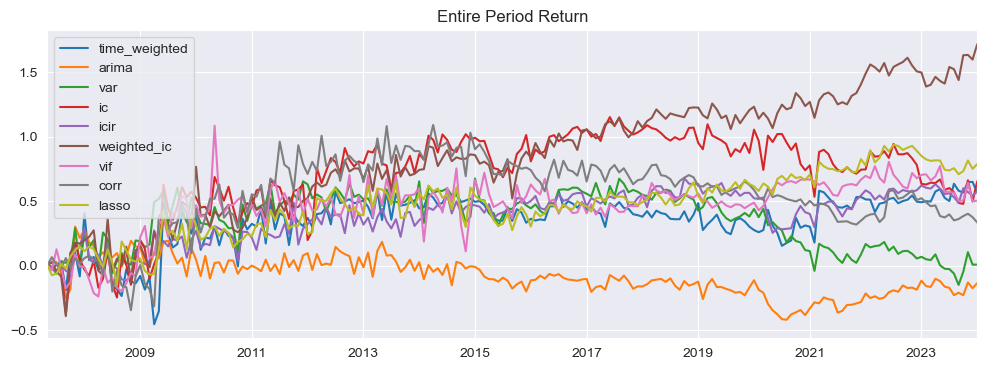

In [97]:
results = {}
for (name, factor_chosen) in all_factor_chosen.items():
    results[name] = backtest_pipe(name=name, factor_chosen=factor_chosen, pred_func=ols_2)
    plt.legend()

In [98]:
pd.DataFrame(results).T.sort_values("sharpe", ascending=False)

,return,mean,std,skew,kurtosis,sharpe,sharpe_mkt,sortino,var,cvar,max_drawdown,downside_beta,alpha,beta_Mkt-RF,beta_SMB,beta_HML,beta_RF
weighted_ic,1.714796,0.008558,0.116885,0.230091,3.593169,0.243967,0.309451,0.356620,-0.512145,-0.936920,-0.519935,-0.001831,9.231867,-2.107174,-0.477257,-21.602094,2263.993721
lasso,0.787180,0.003920,0.090371,0.773312,2.168924,0.137751,0.237953,0.255598,-0.389633,-0.596666,-0.466268,-0.007657,5.355487,-0.621255,-1.072135,-10.154813,641.585086
icir,0.574027,0.002855,0.082551,0.046388,1.739549,0.106090,0.205970,0.158107,-0.423582,-0.619888,-0.466195,0.047613,4.386762,-0.999850,1.053519,-7.411179,548.840827
ic,0.653253,0.003251,0.125784,0.637411,2.974652,0.080522,0.182977,0.136714,-0.636125,-0.892847,-0.685632,-0.086482,9.001263,0.987064,-4.568484,-13.842983,-2129.329045
time_weighted,0.566476,0.002817,0.132269,1.501881,9.214769,0.065223,0.164776,0.106850,-0.748378,-0.955651,-0.794550,0.002836,4.212908,-0.679968,0.969441,-5.371985,-140.629223
vif,0.503134,0.002500,0.136869,0.058989,4.028521,0.055011,0.154275,0.076957,-0.690501,-1.105885,-0.885705,-0.073356,5.744333,-1.046264,0.640685,-12.978867,-1013.689433
corr,0.334374,0.001656,0.124977,1.124322,5.369588,0.036860,0.148059,0.062631,-0.618659,-0.867260,-0.733601,0.057575,7.416062,1.629990,-2.802037,-6.797003,-2624.613550
var,0.007926,0.000024,0.101869,0.471101,2.314293,-0.010274,0.127597,-0.016394,-0.457314,-0.787585,-0.761192,0.037889,5.169021,1.792552,-2.577567,-0.853717,-2700.934252
arima,-0.135480,-0.000693,0.078960,1.222008,6.735652,-0.044721,0.118451,-0.077770,-0.444002,-0.529616,-0.689304,0.029170,-0.846326,-0.358775,3.621118,7.439453,-281.325701


## 3.5.2. Model Combination 
We also investigate if combining several factors could outperform single method. Our combination make use of top 3 methods with the highest sharpe ratio. And using 2 simple combination methods:
1. average of all rank
2. minimum of all rank
3. maximum of all rank

By sharpe ratio, we see the best method is maximum rank of all methods. This could be thanks to a reduction of variance and bias combining different methods. Therefore, in later analysis we would make sure of this max_rank for 

We decided to not include more structured voting tree such as the one in sklearn package since it require all underlying model to follow the same pipeline and structure. It's definitely a area worth further research. However, since modifying all our function into suitable class accepted by sklearn requires considerable time, we regretful forfeit this trial.

In [114]:
combined_df = pd.concat([
    ols_2(ratio, factor_chosen_icir_12, fillna=True).unstack().rank(axis=1),
    ols_2(ratio, factor_chosen_lasso, fillna=True).unstack().rank(axis=1),        
    ols_2(ratio, factor_chosen_weighted_ic_12, fillna=True).unstack().rank(axis=1),
], axis='index', keys=['icir', 'lasso', 'weighted_ic'])
combined_df.index.names = ("method", "date")
combined_df.columns.name = "ticker"

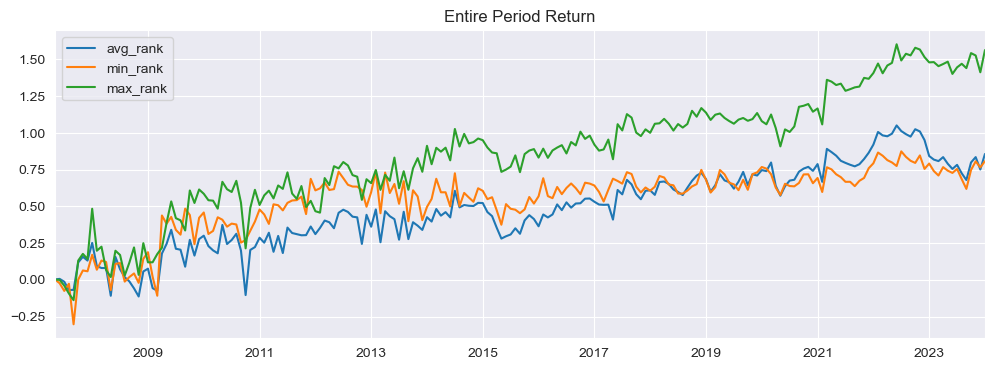

In [115]:
results = {}
for (name, predicted_returns) in [
    ("avg_rank", combined_df.groupby("date").mean()),
    ("min_rank", combined_df.groupby("date").min()),
    ("max_rank", combined_df.groupby("date").max()),
]:
    results[name] = backtest_pipe(
        name=name, 
        predicted_returns=predicted_returns.stack()
    )
    plt.legend()

In [116]:
pd.DataFrame(results).T.sort_values("sharpe", ascending=False)

,return,mean,std,skew,kurtosis,sharpe,sharpe_mkt,sortino,var,cvar,max_drawdown,downside_beta,alpha,beta_Mkt-RF,beta_SMB,beta_HML,beta_RF
max_rank,1.563925,0.007804,0.098888,0.400404,1.373120,0.261943,0.324225,0.454156,-0.469028,-0.652388,-0.445385,-0.025967,9.572780,-1.673482,1.616315,-17.636052,1717.112284
avg_rank,0.857103,0.004270,0.087397,0.377157,1.714094,0.156290,0.250233,0.256453,-0.449519,-0.623361,-0.463805,0.005780,5.318836,-1.604671,0.226099,-13.361162,1121.768442
min_rank,0.808126,0.004025,0.098244,0.831552,5.044879,0.130411,0.233917,0.216889,-0.467673,-0.713382,-0.490974,0.098818,6.528906,-0.633470,-0.624646,-11.462660,-359.736648


In [124]:
best_pred = combined_df.groupby("date").max().loc[TEST_START_DATE:].stack()
best_pred

predicted_ret
date       ticker               
2007-05-31 A               239.0
           AAL             145.0
           AAPL            289.0
           ABT              48.0
           ADBE            203.0
...                          ...
2024-02-29 XYL             329.0
           YUM             248.0
           ZBH             224.0
           ZBRA            270.0
           ZTS             209.0

[72722 rows x 1 columns]

## 3.6. Model Analysis
To obtain deeper understanding model's performance, We investigate the factor selection results by looking into:
1. factor selected 
2. model accuracy for predicted return & ICIR

### 3.6.1 Count how many times each factor has been selected

In [117]:
factor_freq = pd.DataFrame(columns=r_6.index, index=['frequency'])
total_chosen = []
factor_chosen_all = [factor_chosen_time_weight, factor_chosen_arima, factor_chosen_var, factor_chosen_ic, factor_chosen_icir_12, factor_chosen_weighted_ic_12, factor_chosen_corr, factor_chosen_vif, factor_chosen_lasso]
for factor_chosen in factor_chosen_all:
    for i in factor_chosen.values():
        total_chosen += i
for i in factor_freq.columns:
    factor_freq.loc['frequency', i] = round((total_chosen.count(i))/9)
factor_freq = factor_freq.T.sort_values(by='frequency', ascending=False).T
factor_freq

,FI,z_score,alpha6,price_pos,bias,DPO,ret_autocorr,kurt_skew,alpha12,cmo,...,excl_exp,TURN10,oper_profit_margin,ebit_margin,NPR,pretax_profit_margin,VSTD20,AD,VEMA12,RPPS
frequency,134,117,111,107,95,85,84,82,79,73,...,22,21,21,20,19,19,18,16,16,13


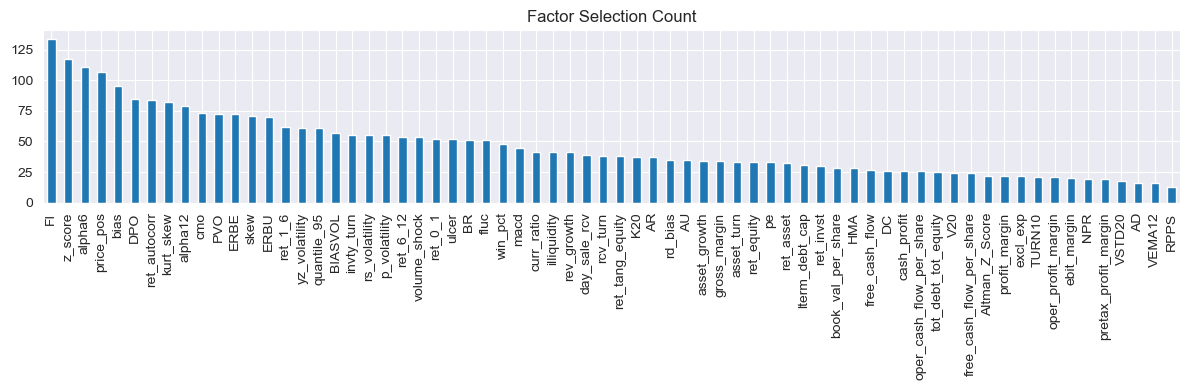

In [118]:
factor_freq.iloc[0, :].plot.bar(figsize=(12, 4), title="Factor Selection Count")
plt.tight_layout()

During our 203 trading days, we choose 'FI', 'AR', 'alpha6', 'z_score', and 'price_pos' most frequently. Every factor has been chosen at least 14 times on average.

### 3.6.2 Factor Selection Accuracy

We use the correlation between **factors' rank by each selection method** and **factor's rank by factor real return** as a metric to evaluate the factor selection accuracy.

In [57]:
factor_ret_rank = factor.copy().shift(-1)
factor_ret_rank = factor_ret_rank[factor_ret_rank.index >= '2007-03-31'].T
for i in factor_ret_rank.columns:
    factor_ret_rank[i] = factor_ret_rank[i].rank()

#### IC selection

In [58]:
ic_sel_accuracy = pd.DataFrame(index=factor_ret_rank.columns, columns=['corr'])
for i in ic_sel_accuracy.index:
    ic_sel_accuracy.loc[i,'corr'] = factor_ret_rank[i].corr(r2[i])
ic_sel_accuracy.T

date,2007-03-31,2007-04-30,2007-05-31,2007-06-30,2007-07-31,2007-08-31,2007-09-30,2007-10-31,2007-11-30,2007-12-31,...,2023-05-31,2023-06-30,2023-07-31,2023-08-31,2023-09-30,2023-10-31,2023-11-30,2023-12-31,2024-01-31,2024-02-29
corr,0.086446,-0.080545,0.069164,0.208355,0.296269,0.415507,-0.034163,0.310101,-0.044232,0.130036,...,0.175066,-0.344579,0.43961,0.041505,0.191793,0.380628,-0.219714,-0.006296,0.125041,NaN


<Axes: title={'center': 'IC Accuracy (Ranking Correlation)'}, xlabel='date'>

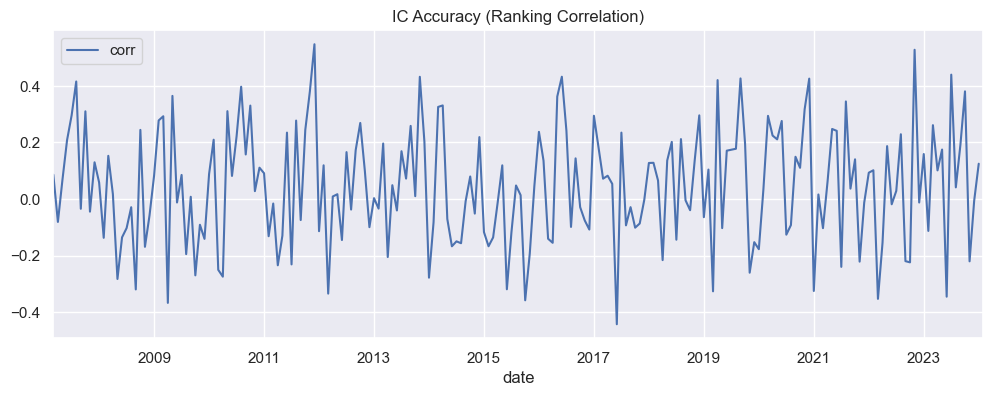

In [59]:
ic_sel_accuracy.plot(figsize=(12, 4), title="IC Accuracy (Ranking Correlation)")

#### Predicted Factor Return selection

In [60]:
pfr_sel_accuracy = pd.DataFrame(index=factor_ret_rank.columns, columns=['corr'])
for i in pfr_sel_accuracy.index:
    pfr_sel_accuracy.loc[i,'corr'] = factor_ret_rank[i].corr(r1[i])
pfr_sel_accuracy.T

date,2007-03-31,2007-04-30,2007-05-31,2007-06-30,2007-07-31,2007-08-31,2007-09-30,2007-10-31,2007-11-30,2007-12-31,...,2023-05-31,2023-06-30,2023-07-31,2023-08-31,2023-09-30,2023-10-31,2023-11-30,2023-12-31,2024-01-31,2024-02-29
corr,0.293951,0.282292,0.15514,0.160875,0.53263,0.516804,0.488361,0.653285,-0.512254,-0.061875,...,0.082353,0.030344,-0.186033,-0.309037,0.163446,-0.217673,0.524781,0.479118,0.513309,NaN


<Axes: title={'center': 'MA Accuracy (Ranking Correlation)'}, xlabel='date'>

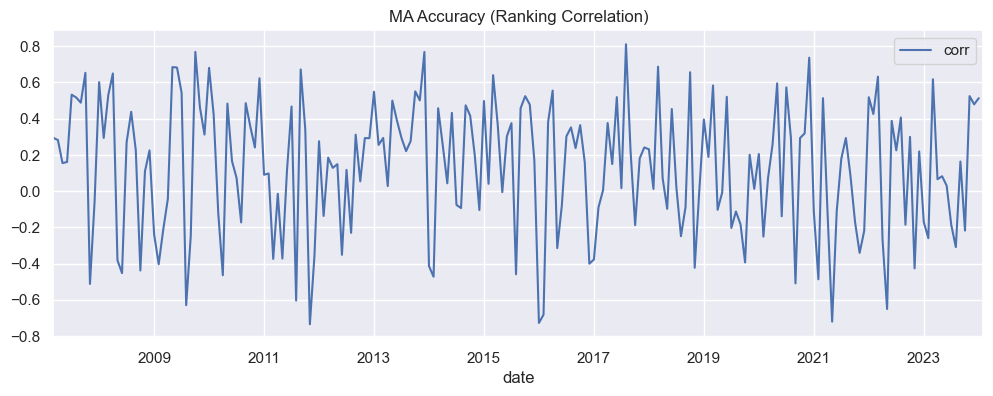

In [61]:
pfr_sel_accuracy.plot(figsize=(12, 4), title="MA Accuracy (Ranking Correlation)")

#### IC and Predicted Factor Return combined selection

In [62]:
combined_sel_accuracy = pd.DataFrame(index=factor_ret_rank.columns, columns=['corr'])
for i in combined_sel_accuracy.index:
    try:
        combined_sel_accuracy.loc[i,'corr'] = factor_ret_rank[i].corr(r[i])
    except Exception as e:
        pass
        # print(e)
combined_sel_accuracy.T

date,2007-03-31,2007-04-30,2007-05-31,2007-06-30,2007-07-31,2007-08-31,2007-09-30,2007-10-31,2007-11-30,2007-12-31,...,2023-05-31,2023-06-30,2023-07-31,2023-08-31,2023-09-30,2023-10-31,2023-11-30,2023-12-31,2024-01-31,2024-02-29
corr,0.283767,0.160485,0.106339,0.244385,0.486853,0.543515,0.323111,0.635031,-0.38207,0.012761,...,0.149556,-0.188984,0.171079,-0.186314,0.227724,0.103994,0.208916,0.309689,0.432938,NaN


In [63]:
factor_ret_rank

date,2007-03-31,2007-04-30,2007-05-31,2007-06-30,2007-07-31,2007-08-31,2007-09-30,2007-10-31,2007-11-30,2007-12-31,...,2023-05-31,2023-06-30,2023-07-31,2023-08-31,2023-09-30,2023-10-31,2023-11-30,2023-12-31,2024-01-31,2024-02-29
curr_ratio,37.0,62.0,44.0,10.0,48.0,21.0,9.0,58.0,23.0,19.0,...,37.0,28.0,14.0,11.0,44.0,59.0,29.0,64.0,56.0,NaN
free_cash_flow_per_share,51.0,15.0,17.0,35.0,16.0,7.0,53.0,19.0,40.0,29.0,...,49.0,63.0,60.0,59.0,46.0,29.0,64.0,56.0,58.0,NaN
ret_equity,20.0,21.0,61.0,40.0,33.0,22.0,57.0,31.0,39.0,10.0,...,38.0,47.0,28.0,36.0,49.0,40.0,48.0,16.0,25.0,NaN
gross_margin,14.0,27.0,26.0,63.0,50.0,37.0,39.0,13.0,21.0,17.0,...,28.0,24.0,35.0,44.0,22.0,21.0,49.0,41.0,41.0,NaN
ret_asset,56.0,25.0,48.0,22.0,13.0,9.0,47.0,44.0,44.0,56.0,...,55.0,60.0,61.0,47.0,10.0,25.0,23.0,27.0,39.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
volume_shock,44.0,38.0,27.0,31.0,24.0,38.0,26.0,50.0,59.0,18.0,...,24.0,38.0,15.0,57.0,37.0,8.0,25.0,8.0,11.0,NaN
rs_volatility,38.0,56.0,32.0,7.0,51.0,54.0,1.0,61.0,29.0,67.0,...,66.0,5.0,5.0,4.0,65.0,65.0,10.0,38.0,36.0,NaN
p_volatility,26.0,52.0,33.0,5.0,52.0,57.0,3.0,60.0,31.0,62.0,...,67.0,12.0,6.0,3.0,66.0,64.0,6.0,35.0,32.0,NaN
yz_volatility,27.0,54.0,41.0,3.0,57.0,59.0,7.0,56.0,24.0,51.0,...,63.0,18.0,9.0,8.0,63.0,61.0,14.0,17.0,18.0,NaN


<Axes: title={'center': 'Combined Accuracy (Ranking Correlation)'}, xlabel='date'>

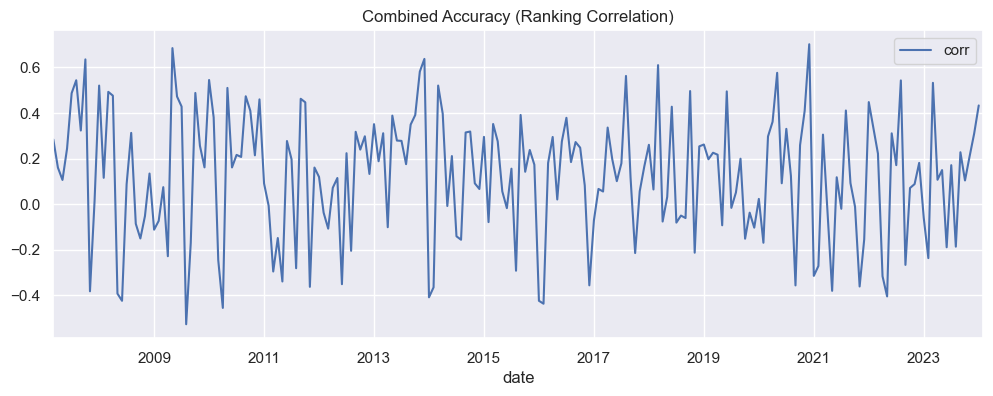

In [64]:
combined_sel_accuracy.plot(figsize=(12, 4), title="Combined Accuracy (Ranking Correlation)")

From the factor selection accuracy metric, we conclude that **the combined selection method outperforms IC selection or Predicted Factor Return selection method.**

# 4. Trade

Based on selected factors, we rank all stocks in our universe (n = 396) at the beginning of each month and then adjust the long-short portfolio.

We assume gross notional on each side to be 1 million with 1 million initial capital, i.e. 2x leverage by notional amount. 

This results in interest income on extra cash on hand and interest receivable / payable from reverse repo - borrowing rate. Since our backtest period went as far as 2007, we use 4-week US Treasury bill rate as the long (i.e. income) rate and estimate short rate with long rate and a spread, e.g. 100bp. We also ignore daily compounding effect for simplification.
1. cash in hand interest = cash in hand (cash - repo cash) * long rate * n_day / 365.25
2. reverse repo interest = reverse repo * short rate (long rate - 100bp) * n_day / 365.25

## 4.1. Single-Stock Ranking

In this part, we aim to predict the stock returns for each month $i$ using the factor values of the previous month $(i-1)$ as explanatory variables. Specifically, we set $X$ to be the matrix of factor values for all $n$ stocks in month $(i-1)$, and $y$ to be the vector of returns for all $n$ stocks in the same month. We then perform a linear regression to model the relationship between the factor values and the stock returns:

$$y_{i-1} = \alpha_{i-1} + \beta_{i-1} \cdot X_{i-1}$$

where $\alpha_{i-1}$ is the intercept and $\beta_{i-1}$ is the vector of coefficients corresponding to each factor. This regression model is fitted using the data from month $(i-1)$.

Once the model is fitted, we use it to predict the returns for month $i$ by applying the estimated coefficients $\alpha_{i-1}$ and $\beta_{i-1}$ to the factor values of month $i$:

$$y_{i} = \alpha_{i-1} + \beta_{i-1} \cdot X_{i}$$

**Note:**  we normalize the factor data before fitting the regression model. This is done because some factors might have values that are significantly larger than others, which could disproportionately influence the results of the regression. By standardizing the data (subtracting the mean and dividing by the standard deviation), we ensure that each factor contributes more equally to the model, leading to more robust predictions.

$$z = \frac{x - \mu}{\sigma}$$


This method provides a way to leverage the information contained in various factors to forecast future stock returns, assuming that the relationships observed in the past will persist in the future. The use of linear regression allows for a straightforward interpretation of the influence of each factor on the predicted returns.

In [65]:
### get the selected factor value df ###
df = ratio.copy()
df.sort_index(level=['date'],ascending=True,inplace=True)
dates = list(factor_chosen.keys())
df = df.loc[dates[0]:]


ratio_new = pd.DataFrame(index=df.index,columns=list(range(1,11)))
for date in dates:
    factor_list = factor_chosen[date]
    ratio_new.loc[date,:] = df.loc[date,factor_list].values
ratio_new = ratio_new.fillna(0)
ratio_new['ret'] = df['ret_0_1']
ratio_new

1         2         3             4           5  \
date       ticker                                                             
2007-05-31 A       170.086771  1.412528  0.846442 -1.694643e+05    0.000000   
           AAL      62.716339 -2.271646  0.864865 -3.703905e+04    0.000000   
           AAPL     81.039175  0.637360  1.000000  3.390628e+06    0.000000   
           ABT      56.768708 -0.473754  0.142061  2.594207e+06    0.309965   
           ADBE     63.923531  2.168600  1.000000  7.300301e+06    0.000000   
...                       ...       ...       ...           ...         ...   
2024-02-29 XYL      11.327752  0.764982  3.229471  3.684487e-01  121.876255   
           YUM       7.880538  0.829037  1.615313  2.018055e-01  132.817239   
           ZBH       2.681000  0.307566  1.229074  2.102450e-01  126.705950   
           ZBRA     27.201000  4.742690  4.975036  1.339685e-01  262.738700   
           ZTS       7.437435  1.012122  0.281594  1.795105e-01  193.722500   

                           6           7         8         9        10  \
date       ticker                                                        
2007-05-31 A        0.343893   -0.490099 -0.171162  2.732500  0.019725   
           AAL     72.028328    0.216540 -0.858346  0.874400  0.031569   
           AAPL     0.000000    1.054980  0.621290  2.922300  0.027681   
           ABT      0.860442    0.621789 -0.711346  0.934900  0.018383   
           ADBE     0.000000    1.096443  0.103327  4.358300  0.025341   
...                      ...         ...       ...       ...       ...   
2024-02-29 XYL      0.854700  119.362991  0.006391  0.616667  1.577200   
           YUM      4.624600  131.892098 -0.266020  0.600000  5.624600   
           ZBH      4.667600  124.322500 -0.363997  0.533333  7.542200   
           ZBRA    -1.759800  264.470000 -0.814591  0.500000 -0.077400   
           ZTS      3.515300  190.845000  0.301469  0.633333  5.090100   

                        ret  
date       ticker            
2007-05-31 A      -0.094154  
           AAL     0.104804  
           AAPL   -0.182395  
           ABT     0.008527  
           ADBE   -0.024198  
...                     ...  
2024-02-29 XYL    -0.110202  
           YUM    -0.056831  
           ZBH    -0.042009  
           ZBRA   -0.083603  
           ZTS    -0.036390  

[72723 rows x 11 columns]

In [66]:
### predict stock return ###
predicted_returns = pd.DataFrame(index=ratio_new.index, columns=['predicted_ret'])
r_square = pd.DataFrame(index=dates, columns=['R-square'])

for i in range(1, len(dates)):
    ratio_i = ratio_new.loc[dates[i - 1],:].fillna(0)
    ratio_i.iloc[:, :-1] = ratio_i.iloc[:, :-1].apply(lambda x:(x-x.mean())/x.std())
    X_train = ratio_i.iloc[:, :-1].values
    y_train = ratio_i.iloc[:, -1].values
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    X_test = ratio_new.loc[dates[i]].iloc[:, :-1].fillna(0).apply(lambda x:(x-x.mean())/x.std())
    y_test = ratio_new.loc[dates[i]].iloc[:, -1].fillna(0)
    
    y_pred = model.predict(X_test)
    
    r_square.loc[dates[i],'R-square'] = r2_score(y_test, y_pred)
    
    predicted_returns.loc[dates[i],'predicted_ret'] = y_pred

predicted_returns = predicted_returns.dropna()
predicted_returns.to_pickle('data/predicted_return.pkl')
predicted_returns

predicted_ret
date       ticker              
2007-06-30 A          -0.019487
           AAL         0.006773
           AAPL       -0.045011
           ABT        -0.022495
           ADBE       -0.007392
...                         ...
2024-02-29 XYL         0.254873
           YUM         0.052852
           ZBH         0.029992
           ZBRA         0.18696
           ZTS        -0.265555

[72398 rows x 1 columns]

We analyze the accuracy of predicted return. For each day, we rank the predicted return and actual return respectively. Then we calculate the correlation between these two ranks on each date.

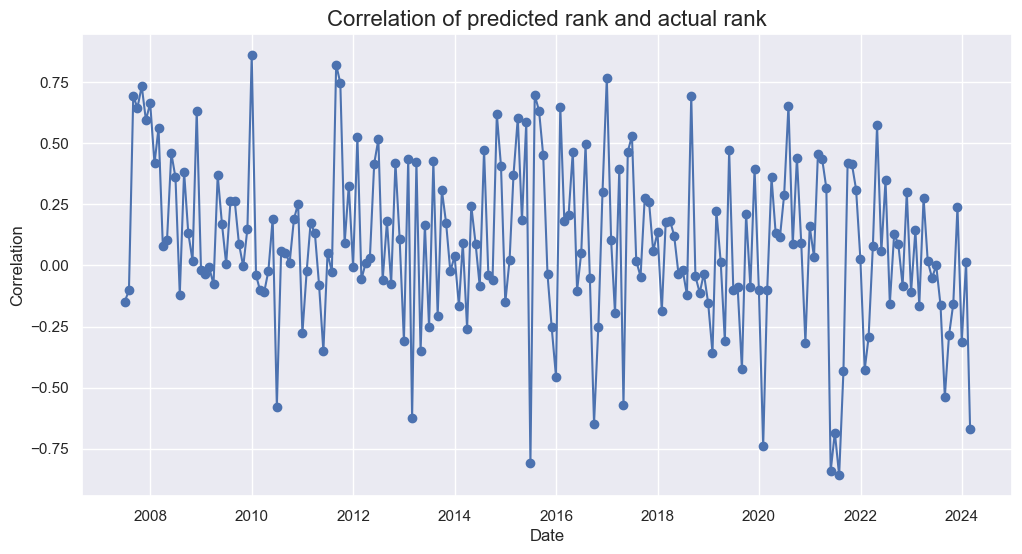

In [67]:
### analyze predict result ###
rank_predicted = predicted_returns.reset_index().pivot(index='date',columns='ticker',values='predicted_ret')
rank_predicted = rank_predicted.apply(lambda x:x.rank(),axis=1).T
rank_actual = ratio_new[['ret']].reset_index().pivot(index='date',columns='ticker',values='ret')
rank_actual = rank_actual.apply(lambda x:x.rank(),axis=1).iloc[1:].T

rank_corr = rank_predicted.corrwith(rank_actual).to_frame()

sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))
plt.plot(rank_corr.index, rank_corr[0], marker='o', linestyle='-', color='b')
plt.title('Correlation of predicted rank and actual rank', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Correlation', fontsize=12)
plt.grid(True)
plt.show()

**Other models for generating predicted stock return (Machine Learning models)**

1. **Random Forests:** This ensemble method uses multiple decision trees to make predictions. It is effective in handling non-linear relationships and can provide insights into the importance of different factors.

2. **Gradient Boosting Machines (GBM):** GBM is another ensemble method that builds trees sequentially, with each tree trying to correct the errors of the previous one. It is known for its high accuracy and ability to handle various types of data.

3. **Support Vector Machines (SVM):** SVM can be used for regression tasks (SVR) and is effective in capturing complex relationships in high-dimensional spaces. It works well with both linear and non-linear data.

4. **Neural Networks:** Deep learning models, such as feedforward neural networks or recurrent neural networks (RNNs), can capture intricate patterns in time series data. They are particularly useful for modeling sequential data and can be trained to predict future returns based on past factor values.

5. **Lasso and Ridge Regression:** These are extensions of linear regression that include regularization terms to prevent overfitting and to handle multicollinearity. They can be useful when dealing with a large number of factors.

6. **XGBoost:** An implementation of gradient boosted trees designed for speed and performance, XGBoost is a popular choice for regression tasks and can handle missing data and various types of features.

## 4.2. Backtest

We adjust our position each month with new ranking:
1. [calc_position_by_rank()](src/trading_stratgy.py) first calculate ideal positions for all tickers in our valid universe by quantile. 
2. [CalcTrade()](src/trading_stratgy.py) iterate through each date and calculate adjusted position / PnL.

We find tickers to buy and tickers to short at each rebalance date (weeks / months) by find top / botton a ~ b% quantile, and then simply allocated the assets by an 1/N rules. 


#### Position Change
For equal-weighted portfolio, to reduce to turnover rate, I only change position when ideal position has different sign from current open position, e.g.
- 100 (long) <-> 0
- -200 (short) <-> 0
- 100 (long) <-> -100 (short)
This would result in the initial equal long / short position went unbalance due to price movement. 

For other portfolio allocation method (i.e. markovitz and capm), portfolio would be adjust by exact weighting each period to fully reflect the optimization effects of these method.


#### Overfitting
We tried to assuage overfitting issue by applying linear models, e.g. linear regression and ranking correlation, which contains less parameter and therefore is harder to overfit as more complicated machine learning tree models.

We understand our conclusion based on entire testing period results implies possible overfitting issue. However, since our focus is to evaluate the validity of this strategy. Including longer samples allows us to make more concrete decision on whether it works.

### 4.2.1. Different Portfolio Allocation

By DeMiguel, Garlappi, & Uppal (2009), this naive allocation strategy actually outperforms many optimization models derived from Markowitz initial mean-variance model due to the lower turnover and data scarcity. They also highlights a potential of constructing optimal portfolio with cross-sectional characteristics (Brandt, Santa-Clara, & Valkanov, 2007). 

Therefore, we construct equal-weighteed portfolios for the benchmark comparison. In addition, we also include:
 1. **Markowitz Portfolio Optimization**: Developed by Harry Markowitz in the 1950s, it focuses on creating an 'efficient frontier' from which investors can choose their optimal portfolio, based on their risk tolerance. It emphasizes the trade-off between risk and return and the benefits of diversification.
2. **CAPM Portfolio Optimization**: Introduced by William Sharpe in the 1960s, CAPM builds on Markowitz's theory but simplifies it by introducing the concept of a market portfolio, systematic risk (beta), and the risk-free rate. CAPM aims to determine the expected return on an investment based on its risk compared to the market.
3. **Sector Neutral Allocation**: Ehsani & Harvey (2023) argued average long–short investor is more likely to benefit from hedging out sector bets.

For CAPM / Markovitz, we understand both method might overfit on the training samples since it's highly unlikely that the future return covariance matrix would be exactly the same as previous return covariance matrix. Therefore, for all method, we use a risk-averse factor = 0.5 to adjust non-diagonal values in covariance matrix.

We won't try Black-Litterman despite its reputation since our portfolio won't hold any assets we perceived to have no information. Factor allocation with our selected factor: this seems to be most prominent however it may lead to very similar results as 1/N portfolio since we also select holdings by factors.

For more details, see [trading_stratgy.py](src/trading_stratgy.py).

References:
Ehsani, S., Harvey, C. R., & Li, F. (2023). Is Sector Neutrality in Factor Investing a Mistake?. Financial Analysts Journal, 1-23.

In [125]:
s_sector = get_zacks(use_cache=True)["zacks_sector_code"].groupby("ticker").last()
s_sector

ticker
A       10.0
AAL     15.0
AAPL    10.0
ABBV     4.0
ABNB    10.0
        ... 
XYL      7.0
YUM      3.0
ZBH      4.0
ZBRA     7.0
ZTS      4.0
Name: zacks_sector_code, Length: 395, dtype: float64

In [169]:
indicator = calc_position_by_rank(
    df_price=price, 
    df_ratio=best_pred.unstack("ticker"),
    rank_formula="-predicted_ret",
    lb=0,
    ub=0.1,
    interval=None,
    use_change=False,
)

indicator_industry = calc_position_by_industry(
    s_sector=s_sector,
    df_price=price, 
    df_ratio=best_pred.unstack("ticker"),
    rank_formula="-predicted_ret",
    lb=0.1,
    ub=0,
    interval=None,
    use_change=False,
)

We first calculate position indicators (i.e. 1 for long position, -1 for short position) with the best prediction result for base scenario and sector neutral scenario, i.e. indicator_industry above.

For the sector neutral scenario, we make use of Zacks sector code and make sure same asset size in each available sector.

In [173]:
positions = {
    "equal_weighted": portfolio_equal_weighted(
        position_indicator=indicator,
        df_price=price,
        position_size=INIT_CAPITAL,
    ),
    "sector_neutral": portfolio_equal_weighted(
        position_indicator=indicator_industry,
        df_price=price,
        position_size=INIT_CAPITAL,
    ),
    "capm_positive":  portfolio_capm_optimized(
        df_ratio=ratio, 
        df_price=price,
        df_ff=df_ff,
        estimation_month=60,
        position_size=INIT_CAPITAL,
        position_indicator=indicator,
    ),
    "markovitz_positive": portfolio_markovitz_optimized(
        df_ratio=ratio, 
        df_price=price,
        estimation_month=60,
        position_size=INIT_CAPITAL,
        position_indicator=indicator,  
    ),
    "markovitz": portfolio_markovitz_optimized(
        df_ratio=ratio, 
        df_price=price,
        estimation_month=60,
        position_size=INIT_CAPITAL,
        position_indicator=indicator,  
        optimize_kwargs={"positive_weight": False}
    ),
}

Problem does not follow DCP rules. Specifically:
The objective is not DCP. Its following subexpressions are not:
QuadForm(var156215, [[0.01 0.00 ... 0.00 0.00]
 [0.00 0.01 ... 0.00 0.00]
 ...
 [0.00 0.00 ... 0.03 -0.00]
 [0.00 0.00 ... -0.00 0.00]])
Problem does not follow DCP rules. Specifically:
The objective is not DCP. Its following subexpressions are not:
QuadForm(var156231, [[0.00 0.00 ... -0.00 -0.00]
 [0.00 0.02 ... 0.00 0.01]
 ...
 [-0.00 0.00 ... 0.00 0.00]
 [-0.00 0.01 ... 0.00 0.04]])
Problem does not follow DCP rules. Specifically:
The objective is not DCP. Its following subexpressions are not:
QuadForm(var156247, [[0.01 0.00 ... -0.00 0.00]
 [0.00 0.00 ... 0.00 0.00]
 ...
 [-0.00 0.00 ... 0.03 -0.02]
 [0.00 0.00 ... -0.02 0.03]])
Problem does not follow DCP rules. Specifically:
The objective is not DCP. Its following subexpressions are not:
QuadForm(var156383, [[0.01 -0.00 ... 0.00 0.00]
 [-0.00 0.04 ... 0.00 0.00]
 ...
 [0.00 0.00 ... 0.02 0.00]
 [0.00 0.00 ... 0.00 0.03

We then calculate assigned position, i.e. number of stock to hold, at each time period for each method. The methods are:
1. Equal weighted
2. Sector neutral equal weighted
3. Markovitz with any / all positive weights 
4. CAPM with any / all positive weights 

For more details, e.g. parameters selction, see [portfolio_allocation_capm.ipynb](src/portfolio_allocation_capm.ipynb), [portfolio_allocation_industry_neutral.ipynb](src/portfolio_allocation_industry_neutral.ipynb), [portfolio_allocation_Markowitz.ipynb](src/portfolio_allocation_Markowitz.ipynb). 

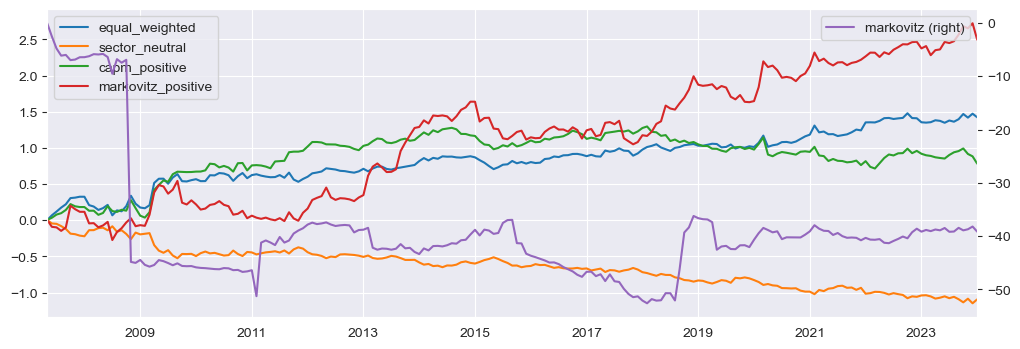

In [174]:
trade_cls = CalcTrade(
    df_price=price,
    init_cap=INIT_CAPITAL,
    adj_small_change=True
)

results = {}
for name, position in positions.items():
    summary_df = trade_cls.iter_dates(position=position)
    if name == "markovitz":
        summary_df["total_ret"].rename(name).plot(figsize=(12,4), secondary_y=True)
        plt.legend()
    else:
        summary_df["total_ret"].rename(name).plot(figsize=(12,4))
        plt.legend()
    results[name] = eval_return(summary_df["total_ret"], df_ff=df_ff, ann_factor=12)

In [175]:
pd.DataFrame(results).T.sort_values("sharpe", ascending=False)

,return,mean,std,skew,kurtosis,sharpe,sharpe_mkt,sortino,var,cvar,max_drawdown,downside_beta
equal_weighted,1.422833,0.007099,0.047902,0.876338,8.351026,0.489833,0.404661,0.719606,-0.229335,-0.357377,-0.242954,0.225803
markovitz_positive,2.495622,0.012463,0.092961,0.133748,2.430920,0.452219,0.478128,0.657853,-0.434700,-0.690439,-0.526661,0.247794
capm_positive,0.782176,0.003885,0.052139,0.583562,7.210353,0.236345,0.285424,0.358933,-0.243305,-0.375319,-0.485894,0.063103
markovitz,-39.160670,-0.195470,3.006958,-9.763539,126.159168,-0.225563,-0.219283,-0.181579,-4.728029,-23.315066,-3.177537,0.057078
sector_neutral,-1.092689,-0.005479,0.031170,-0.402345,3.424732,-0.644593,-0.025748,-0.917565,-0.164422,-0.267863,-0.699601,-0.227458


Above table and plot show the performance of all portfolio allocation methods. Beware that the return of Markovitz with any weights is shown on the right side due to its highly volatile nature and arbitrarily high weights on each asset. This ensures all line is present with notable trend in the same chart.

Here are some finds:
- Our conclusion is similar to the same as DeMiguel, the native equal-weighted portfolio performs surprisingly well, followed by Markovitz optimization with enforced all positive weights. Positive weight constraint effectively improve markovitz's performance by removing dubious large positions.
- CAMP failed to outperform Markovitz in our test. This could be because our estimation of beta is too simple to fully exploit the value of beta based expected return in mean-variance optimization. For further research, we may like to use beta from Bloomberg to construct more appropriate beta-estimated returns.
- Sector neutral portfolio also performances badly in our testing. Some improvement could be made in constructing sector-neutral portfolio instead of forcing equal exposure on all available sectors.

### 4.2.2. Different Trading Cost

We then investigate the effect of trading cost on our best portfolio - equal weighted portfolio. We test cost = 0, 0.001, or 0.01.

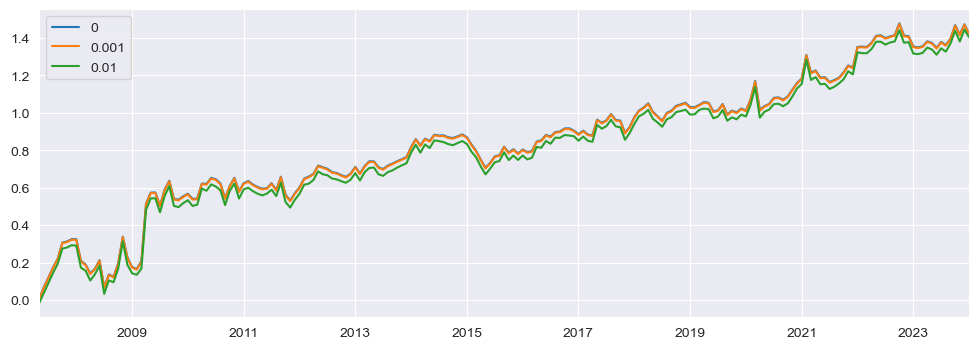

In [189]:
results = {}
ff_results = {}

for c in [0, 1e-3, 1e-2]:
    trade_cls = CalcTrade(
        df_price=price,
        init_cap=INIT_CAPITAL,
        adj_small_change=True,
        cost=c
    )
    summary_df = trade_cls.iter_dates(position=positions["equal_weighted"])
    summary_df["total_ret"].rename(c).plot(figsize=(12,4))
    plt.legend()
    results[c] = eval_return(summary_df["total_ret"], df_ff=df_ff, ann_factor=12)
    ff_results[c] = ff_decomposition(summary_df["total_ret"], df_ff=df_ff, ann_factor=12)

In [190]:
pd.DataFrame(results).T.sort_values("sharpe", ascending=False)

,return,mean,std,skew,kurtosis,sharpe,sharpe_mkt,sortino,var,cvar,max_drawdown,downside_beta
0.000,1.422833,0.007099,0.047902,0.876338,8.351026,0.489833,0.404661,0.719606,-0.229335,-0.357377,-0.242954,0.225803
0.001,1.420864,0.007099,0.048103,0.861523,8.292196,0.487804,0.404209,0.714944,-0.229800,-0.360137,-0.243338,0.225101
0.010,1.403149,0.007101,0.050079,0.726908,7.695729,0.468673,0.399813,0.677185,-0.233987,-0.384976,-0.246856,0.218399


In [191]:
pd.DataFrame(ff_results).T

,alpha,beta_Mkt-RF,beta_SMB,beta_HML,beta_RF
0.000,9.411912,-1.183132,-0.643359,-17.321586,1564.559541
0.001,9.370802,-1.186219,-0.647857,-17.320617,1566.332982
0.010,9.000806,-1.214003,-0.688346,-17.311902,1582.293952


We can trading cost only have marginal effects on our strategy. If cost = 0.001, the difference is barely noticeable, while if cost = 0.01, the strategy is still relatively attractive compared to other methods.

### 4.2.3. Risk Analysis
Our strategy also shows a extremely high kurtosis and a positive skewness, which concerns us about the tail risk of this portfolio.

But at the same time, regardless of the trading cost level, we can see the VaR, CVaR, and max_drawdown is relatively low compared to the return level, which indicates a controllable tail risk.

However, we also decent position downside beta, which shows our strategy is to some degree align with market portfolio in downward market. Therefore, it may not a good strategy for diversification in additional to passive market portfolio. 

# 5. Conclusion

In summary, we find there are some merit of this dynamic method. Using voting rank of several factor selection model effective improve the pipeline performance. This method also free us from manually evaluating the pros and cons of each factor, which allows a easier process for future adding new factors. The 0.01 trading cost scenario shows a decent sharpe ratio of 0.47, which is much better than most of the single factor quantile trading strategy tested over the same period.

#### Future Improvements

**1. Future improvements in time series forcasting**

We can apply other models to predict the factor return
1. **RNN, e.g. LSTM (Long Short-Term Memory) / GRU:** This type of recurrent neural network is well-suited for modeling time series data due to its ability to capture long-term dependencies. LSTMs have shown promising results in various forecasting tasks.


**2. Other methods in choosing factors**

1. **Factor Z-Score:** Standardize both factor return and factor IC value by converting them into z-scores. Then, you can combine these z-scores into a single composite score, which can provide a standardized measure of factor performance.

2. **Principal Component Analysis (PCA):** PCA can be used to reduce the dimensionality of the data by combining the two indicators into a single principal component that captures the majority of the variance in the data.